# **Identifying Franchise Potential in Manga Source Material**

**A Retrospective Classification Analysis of Community Metrics**

Author: Kenneth Young

Date: December 2025

**Platform:** [MyAnimeList Dataset (Kaggle) ](https://www.kaggle.com/datasets/andreuvallhernndez/myanimelist)    

In [285]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast  # Library for parsing strings like "['Action', 'Adventure']" into actual lists
import re   # Regex for string manipulation
import os
import sys
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split


# Set visual style for the notebook
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# 1. Introduction

## 1.1 Problem Statement
**Objective**: The anime industry is a multi-billion dollar market heavily reliant on adapting existing source material (Manga, Light Novels). However, only a small fraction of published works receive adaptations. This project aims to build a machine learning *classification model* to identify the statistical profile of manga that sustain a multimedia franchise.

**The Challenge (Data Causality)**: We are analyzing a static dataset (collected in 2023). This introduces a "Causality Dilemma":

*    **Ideal Scenario**: We would use historical data to predict its adaptation in a later year.

*    **Actual Scenario**: We only have current metrics. A manga's current popularity (members) is often inflated because it received an anime adaptation (Reverse Causality).

**Analysis Strategy**: To mitigate this "Post-Adaptation Bias," we will engineer features that focus on intrinsic properties (Density, Ratios) rather than raw totals. We define the problem not as "Forecasting," but as "Franchise Characterization": Can we distinguish the signal of a commercially viable property from the noise of the general market, even with the presence of retrospective bias?

## 1.2 Data Source & Scope

**Source**: The dataset is a snapshot of MyAnimeList.net (MAL), the world's largest active anime and manga community. It was scraped using the Jikan API and hosted on Kaggle by Andreu Vall Hernàndez.

**URL**: https://www.kaggle.com/datasets/andreuvallhernndez/myanimelist

**Dataset Composition**: The analysis utilizes two distinct files:

1.  `manga.csv` **(The Features)**: Contains ~67,000 entries of source material, including metadata (Authors, Genres), status (Publishing/Finished), and community metrics (Score, Members).

2.    `anime.csv` **(The Reference)**: Contains ~24,000 entries of animated works. This file is used primarily as a "Lookup Table" to determine if a manga has been adapted.

**Scope of Analysis**: We restrict our analysis to Mainstream Original Source Material. To ensure we are modeling commercial viability for the general market, we filter out:

*    *Doujinshi* (Fan-made comics)

*    *Manhwa/Manhua* (Korean/Chinese comics, unless explicitly adapted)

*    *One-shots* (Single chapters)

*    *Adult Content* (Hentai/Erotica): These works operate in a distinct market with different production incentives and are excluded from this analysis.

## 1.3 Target Variable Definition

**Variable Name**: `is_adapted` (Binary: 0 or 1)

**Definition**: A manga is considered "Adapted" (1) if it shares a verified intellectual property link with an entry in the Anime database.

**Challenge**: There is no shared ID column between the two datasets. We cannot simply join on ID. Instead, we must perform set-based entity resolution based on titles. A match is defined as:

*    Exact Title Match: (e.g., One Piece ↔ One Piece)

*    Cross-Language Match: (e.g., Shingeki no Kyojin ↔ Attack on Titan)

*    Synonym Match: (e.g., DanMachi ↔ Is It Wrong to Try to Pick Up Girls in a Dungeon?)

## 1.4 Data Dictionary & Feature Types

The dataset contains 31 columns. We categorize them below to structure our auditing and feature engineering process.

**A. Target Variable**
| Feature | Type | Description |
| :--- | :--- | :--- |
| **`is_adapted`** | *Binary* | **Derived.** `1` if the manga has an anime adaptation (TV, Movie, OVA), `0` otherwise. Generated via Entity Resolution. |

**B. Numerical Features (Quantitative)**
| Feature | Description | Potential Issues |
| :--- | :--- | :--- |
| **`score`** | MAL community score (0.00 – 10.00). | High missingness (~60%) for obscure works. Subject to "Niche Inflation." |
| **`members`** | Number of users who added the manga to their list. | Extreme positive skew (Power Law). Requires Log Transformation. |
| **`favorites`** | Number of users who marked it as a "Favorite." | Highly collinear with `members`. Likely redundant. |
| **`volumes`** | Total published volumes. | Missing for ongoing series. Used to calculate "Density" metrics. |
| **`chapters`** | Total published chapters. | Redundant with `volumes`, but more granular. |
| **`start_year`** | Year of serialization start. | Used for temporal filtering (Look-ahead bias check). |

**C. Categorical Features (Qualitative)**
| Feature | Description | Processing Strategy |
| :--- | :--- | :--- |
| **`type`** | Media format (Manga, Novel, One-shot). | One-Hot Encode. Filter out non-standard formats (Doujinshi). |
| **`genres`** | List of genres (Action, Comedy). | Multi-label. Requires parsing and One-Hot Encoding. |
| **`themes`** | List of themes (Isekai, School). | High sparsity, but low cardinality. Requires frequency pruning. |
| **`demographics`** | Target audience (Shonen, Seinen). | High signal. One-Hot Encode. |
| **`serializations`** | Magazine name (e.g., *Shonen Jump*). | High cardinality (>2k magazines). Requires "Top-K" encoding. |
| **`authors`** | Writer/Artist names. | Too sparse for modeling. Will be discarded or simple-counted. |
| **`sfw`** | Safe For Work flag (True/False). | Used as a hard filter to exclude Hentai/Erotica. |

**D. Metadata (To Be Dropped)**
* **Identifiers:** `manga_id`, `title`, `title_english`, `title_japanese`, `url`.
* **Visuals:** `main_picture` (URL to poster).
* **Administrative:** `approved`, `created_at`, `updated_at`, `background`, `synopsis`.

## 1.5 Methodology Roadmap

1.    **Entity Resolution**: Constructing the is_adapted ground truth via set intersection of multi-language Alias Sets.

2.    **EDA & Audit**: verifying the "Recency Bias" (dropping new manga) and Multicollinearity.

3.    **Feature Engineering**: Implementing Cost-Sensitive Learning features (e.g., members_per_volume) and parsing stringified categorical lists.

4.    **Modeling Strategy**:

        *    *Baseline*: Logistic Regression to establish a performance floor and assess feature linearity.

        *    *Regulurized Baseline*: Regularized Logistic Regression (LASSO) to compare the effects of regularization on the baseline.

        *    *Candidate Models*: Tree-Based Ensembles (Random Forest) to capture non-linear interactions and handle outliers.

5.    **Robust Evaluation**:

        *    *Stratified Cross-Validation*: To ensure stability given the severe class imbalance (~95% non-adapted).

       *    *Metric Optimization*: Focusing on Precision-Recall (F1-Score) over Accuracy.

## 1.6 Environment Setup & Data Ingestion

We utilize the Kaggle API to programmatically download the dataset. We implement a standard directory structure (`01_raw`, `02_interim`, `03_processed`) to ensure the analysis is reproducible and raw data remains immutable.

### 1.6.1 Kaggle Setup

In [220]:
# Environment Detection & Kaggle Setup
try:
    from google.colab import drive
    IN_COLAB = True
    PROJECT_ROOT = '.' # Colab is always flat
    
    print("Running in Google Colab. Setting up environment...")
    
    # Install Kaggle API
    %pip install -q kaggle
    
    # Mount Drive (to access kaggle.json)
    drive.mount('/content/drive')
    
    # Credentials Setup
    !mkdir -p ~/.kaggle
    !cp /content/drive/MyDrive/KaggleCredentials/kaggle.json ~/.kaggle/kaggle.json
    !chmod 600 ~/.kaggle/kaggle.json
    
    print("Colab setup complete.")

except ImportError:
    IN_COLAB = False
    print("Running locally.")
    
    # Automatic Project Root Detection (looks for .git)
    current_dir = os.path.abspath(os.getcwd())
    while True:
        if '.git' in os.listdir(current_dir):
            PROJECT_ROOT = current_dir
            break
        parent = os.path.dirname(current_dir)
        if parent == current_dir: 
            PROJECT_ROOT = os.getcwd() # Fallback
            break
        current_dir = parent
        
    print("Ensure 'kaggle.json' is in your local ~/.kaggle/ directory.")

Running locally.
Ensure 'kaggle.json' is in your local ~/.kaggle/ directory.


In [243]:
# Import Kaggle and 
import kaggle

# Directory Structure
if IN_COLAB:
    raw_dir = '.'
    interim_dir = '.'
    processed_dir = '.'
    img_dir = 'images'
    os.makedirs(img_dir, exist_ok=True)
else:
    raw_dir = os.path.join(PROJECT_ROOT, 'data', '01_raw')
    interim_dir = os.path.join(PROJECT_ROOT, 'data', '02_interim')
    processed_dir = os.path.join(PROJECT_ROOT, 'data', '03_processed')
    img_dir = os.path.join(PROJECT_ROOT, 'images')
    
    for d in [raw_dir, interim_dir, processed_dir, img_dir]:
        os.makedirs(d, exist_ok=True)


In [244]:
# Download Data
dataset = 'andreuvallhernndez/myanimelist'
anime_path = os.path.join(raw_dir, 'anime.csv')
manga_path = os.path.join(raw_dir, 'manga.csv')

# Only download if files are missing
if not os.path.exists(anime_path) or not os.path.exists(manga_path):
    print(f"\nFiles not found. Downloading {dataset}...")
    kaggle.api.dataset_download_files(dataset, path=raw_dir, unzip=True)
    print("Download complete.")
else:
    print(f"\nData already exist. Skipping download.")


Data already exist. Skipping download.


### 1.6.2 Load Data

In [223]:
# Load Data
anime_df = pd.read_csv(anime_path, low_memory=False)
manga_df = pd.read_csv(manga_path, low_memory=False)

print(f"\nLoaded Anime Data: {anime_df.shape}")
print(f"Loaded Manga Data: {manga_df.shape}")

print("\n--- Preview: Anime Data ---")
display(anime_df.head(3))
print("\n--- Preview: Manga Data ---")
display(manga_df.head(3))


Loaded Anime Data: (24985, 39)
Loaded Manga Data: (64833, 30)

--- Preview: Anime Data ---


,anime_id,title,type,score,scored_by,status,episodes,start_date,end_date,source,...,producers,licensors,synopsis,background,main_picture,url,trailer_url,title_english,title_japanese,title_synonyms
0,5114,Fullmetal Alchemist: Brotherhood,tv,9.10,2037075,finished_airing,64.0,2009-04-05,2010-07-04,manga,...,"['Aniplex', 'Square Enix', 'Mainichi Broadcast...","['Funimation', 'Aniplex of America']",After a horrific alchemy experiment goes wrong...,NaN,https://cdn.myanimelist.net/images/anime/1208/...,https://myanimelist.net/anime/5114/Fullmetal_A...,https://www.youtube.com/watch?v=--IcmZkvL0Q,Fullmetal Alchemist: Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,['Hagane no Renkinjutsushi: Fullmetal Alchemis...
1,11061,Hunter x Hunter (2011),tv,9.04,1671587,finished_airing,148.0,2011-10-02,2014-09-24,manga,...,"['VAP', 'Nippon Television Network', 'Shueisha']",['VIZ Media'],Hunters devote themselves to accomplishing haz...,NaN,https://cdn.myanimelist.net/images/anime/1337/...,https://myanimelist.net/anime/11061/Hunter_x_H...,https://www.youtube.com/watch?v=D9iTQRB4XRk,Hunter x Hunter,HUNTER×HUNTER（ハンター×ハンター）,['HxH (2011)']
2,38524,Shingeki no Kyojin Season 3 Part 2,tv,9.05,1491491,finished_airing,10.0,2019-04-29,2019-07-01,manga,...,"['Production I.G', 'Dentsu', 'Mainichi Broadca...",['Funimation'],Seeking to restore humanity's diminishing hope...,Shingeki no Kyojin adapts content from volumes...,https://cdn.myanimelist.net/images/anime/1517/...,https://myanimelist.net/anime/38524/Shingeki_n...,https://www.youtube.com/watch?v=hKHepjfj5Tw,Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,[]



--- Preview: Manga Data ---


,manga_id,title,type,score,scored_by,status,volumes,chapters,start_date,end_date,...,demographics,authors,serializations,synopsis,background,main_picture,url,title_english,title_japanese,title_synonyms
0,2,Berserk,manga,9.47,319696,currently_publishing,NaN,NaN,1989-08-25,NaN,...,['Seinen'],"[{'id': 1868, 'first_name': 'Kentarou', 'last_...",['Young Animal'],"Guts, a former mercenary now known as the ""Bla...",Berserk won the Award for Excellence at the si...,https://cdn.myanimelist.net/images/manga/1/157...,https://myanimelist.net/manga/2/Berserk,Berserk,ベルセルク,['Berserk: The Prototype']
1,13,One Piece,manga,9.22,355375,currently_publishing,NaN,NaN,1997-07-22,NaN,...,['Shounen'],"[{'id': 1881, 'first_name': 'Eiichiro', 'last_...",['Shounen Jump (Weekly)'],"Gol D. Roger, a man referred to as the ""King o...",One Piece is the highest selling manga series ...,https://cdn.myanimelist.net/images/manga/2/253...,https://myanimelist.net/manga/13/One_Piece,One Piece,ONE PIECE,[]
2,1706,JoJo no Kimyou na Bouken Part 7: Steel Ball Run,manga,9.30,151433,finished,24.0,96.0,2004-01-19,2011-04-19,...,"['Seinen', 'Shounen']","[{'id': 2619, 'first_name': 'Hirohiko', 'last_...",['Ultra Jump'],"In the American Old West, the world's greatest...",JoJo no Kimyou na Bouken Part 7: Steel Ball Ru...,https://cdn.myanimelist.net/images/manga/3/179...,https://myanimelist.net/manga/1706/JoJo_no_Kim...,NaN,ジョジョの奇妙な冒険 Part7 STEEL BALL RUN,"[""JoJo's Bizarre Adventure Part 7: Steel Ball ..."


# 2. Data Engineering: Target Variable Creation

**Objective**: Since the dataset lacks a direct link between the Manga and Anime files, we must engineer a target variable is_adapted.

**Hypothesis & Success Criteria**:

*    *Rarity*: Based on industry knowledge, I expect the adaptation rate to be low (roughly 5-10%).

*    *Recall*: Major hits (One Piece, Naruto) must be identified as True.

*    *Specificity*: Famous un-adapted works (Vagabond, Oyasumi Punpun) must be identified as False.

**Methodology**: We will use a set-based entity resolution approach, checking for exact set intersections across English, Romaji, and Japanese titles to maximize recall.

## 2.1 Data Quality Audit
Before building the logic, we must check for the stringified list issue common in scraped CSVs (where lists are stored as strings like `"['Action', 'Comedy']"`). We will also check for duplicates in the manga dataset. Since the dataset includes both manga and light novels, we will expect some entries to have duplicate titles. However, if the duplicates have identical `title` and `type`, we will keep the one with the most metadata (highest `members` count) and drop the rest.

### Check for Stringified List


In [224]:
print("--- Checking for Stringified List ---")
# Check the first non-null entry in 'genres' to see if it's a String or List
sample_genre = manga_df['genres'].dropna().iloc[0]

print(f"Sample Entry: {sample_genre}")
print(f"Detected Type: {type(sample_genre)}")

if isinstance(sample_genre, str) and "[" in sample_genre:
    print(">>> ALERT: Columns are stringified lists. We will need ast.literal_eval in Section 5.")
else:
    print(">>> STATUS: Columns are already native List objects.")

--- Checking for Stringified List ---
Sample Entry: ['Action', 'Adventure', 'Award Winning', 'Drama', 'Fantasy', 'Horror', 'Supernatural']
Detected Type: <class 'str'>
>>> ALERT: Columns are stringified lists. We will need ast.literal_eval in Section 5.


### Check for Duplicates

In [225]:
# ==========================================
# 2.1b DUPLICATE & INTEGRITY CHECK
# ==========================================

print("--- Integrity Check ---")

# 1. Check for Duplicate IDs
duplicates = manga_df[manga_df.duplicated(subset='manga_id', keep=False)]
print(f"Duplicate IDs found: {len(duplicates)}")

if len(duplicates) > 0:
    print(">>> ACTION: Dropping duplicates...")
    # Keep the first occurrence, drop the rest
    manga_df = manga_df.drop_duplicates(subset='manga_id', keep='first').reset_index(drop=True)
    print(f"New Dataset Size: {len(manga_df)}")
else:
    print(">>> STATUS: Dataset IDs are unique.")

# 2. Check for Title Duplicates
# Sometimes the same manga is listed twice with different IDs (e.g. re-releases)
title_dupes = manga_df[manga_df.duplicated(subset='title', keep=False)]
if len(title_dupes) > 0:
    print(f"Note: {len(title_dupes)} entries share the same 'title'. This is common for re-releases or light novel adaptations.")
    # We keep these because they might be distinct entries (Manga vs LN)
    # The 'type' column will differentiate them.

--- Integrity Check ---
Duplicate IDs found: 0
>>> STATUS: Dataset IDs are unique.
Note: 4601 entries share the same 'title'. This is common for re-releases or light novel adaptations.


In [226]:
# Check duplicates based on Title
dupe_titles = manga_df[manga_df.duplicated(subset='title', keep=False)]

print(f"Entries with shared titles: {len(dupe_titles)}")

# Check if they have different types
# We group by Title and count how many unique types exist for that title
title_type_counts = dupe_titles.groupby('title')['type'].nunique()

print("\n--- Diagnostic: Why are they duplicates? ---")
print(f"Titles with multiple DIFFERENT types (e.g. Manga + LN): {sum(title_type_counts > 1)}")
print(f"Titles with EXACT SAME type (True Duplicates): {sum(title_type_counts == 1)}")

# Show examples of "True Duplicates" to see what we are dealing with
true_dupes_mask = dupe_titles['title'].isin(title_type_counts[title_type_counts == 1].index)
print("\n--- Example of True Duplicates (Same Title + Same Type) ---")
display(dupe_titles[true_dupes_mask].sort_values('title').head(6)[['manga_id', 'title', 'type', 'members', 'authors']])

Entries with shared titles: 4601

--- Diagnostic: Why are they duplicates? ---
Titles with multiple DIFFERENT types (e.g. Manga + LN): 1705
Titles with EXACT SAME type (True Duplicates): 477

--- Example of True Duplicates (Same Title + Same Type) ---


,manga_id,title,type,members,authors
6639,20591,15: Meisetsu Kougyou Koukou Rugby-bu,manga,1927,"[{'id': 7650, 'first_name': 'Yoshiki', 'last_n..."
9443,20051,15: Meisetsu Kougyou Koukou Rugby-bu,manga,950,"[{'id': 7650, 'first_name': 'Yoshiki', 'last_n..."
6365,9135,17,manga,2254,"[{'id': 4581, 'first_name': 'Machiko', 'last_n..."
30137,116515,17,manga,230,"[{'id': 3122, 'first_name': 'Keiko', 'last_nam..."
10660,14855,17-sai,manga,3855,"[{'id': 6668, 'first_name': 'Rin', 'last_name'..."
57029,147229,17-sai,manga,39,"[{'id': 26041, 'first_name': 'Baron', 'last_na..."


### Remove Duplicates

In [227]:
print(f"\n--- Deduplication Strategy ---")
initial_rows = len(manga_df)

# Sort by members (descending) so the "best" entry comes first
manga_df = manga_df.sort_values(by='members', ascending=False)

# Drop duplicates where BOTH Title and Type are the same
# keep='first' retains the entry with the highest members (since we sorted)
manga_df = manga_df.drop_duplicates(subset=['title', 'type'], keep='first')

rows_dropped = initial_rows - len(manga_df)
print(f"Dropped {rows_dropped} entries that were identical (Title + Type).")
print(f"New Dataset Size: {len(manga_df)}")

# Reset index after dropping
manga_df = manga_df.reset_index(drop=True)


--- Deduplication Strategy ---
Dropped 676 entries that were identical (Title + Type).
New Dataset Size: 64157


## 2.2 Text Normalization & Logic Setup

First, we define the cleaning rules. Since titles vary wildly between databases (e.g., "Attack on Titan" vs "Shingeki no Kyojin"), we need a strict normalization function to strip noise while preserving the Japanese characters that help us identify native matches.

In [228]:
# Define Valid Sources
# We only care about anime adapted from print media (Manga, LN, etc.)
valid_sources = ['manga', 'light_novel', 'web_manga', '4_koma_manga']
anime_adapted = anime_df[anime_df['source'].isin(valid_sources)].copy()
print(f"Filtered Anime Database: {len(anime_adapted)} entries sourced from Manga/LN.")

# Define Text Normalization (Strict Mode)
def normalize_text(text):
    """
    Cleans text for set matching.
    - Lowercases and strips whitespace.
    - Removes anime suffixes (Season 2, Movie, etc.).
    - Removes punctuation but KEEPS Japanese characters (\w matches Kanji/Kana).
    - Enforces minimum length to prevent 'empty' or single-char false positives.
    """
    if pd.isna(text):
        return set()
    
    # Lowercase and convert to string
    text = str(text).lower().strip()
    
    # Remove Suffixes
    text = re.sub(r'(:? season \d+| the movie| part \d+)', '', text)
    
    # Remove Punctuation (Keep alphanumeric + Japanese)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.strip()
    
    # Length Check: Ignore strings shorter than 2 chars (e.g. "a", "1")
    if len(text) < 2:
        return set()
        
    return {text}

Filtered Anime Database: 6475 entries sourced from Manga/LN.


## 2.3 Building the Reference Set (Whitelist)

We construct a reference set for every anime. This involves collecting the English, Romaji, Japanese, and Synonym titles into a single Set object. Using a Set allows for O(1) lookup speeds, making the matching process instantaneous.

In [229]:
# We use a Set data structure for O(1) lookup speed.
anime_reference_set = set()

for _, row in anime_adapted.iterrows():
    # Collect all known aliases for the anime entity
    anime_reference_set.update(normalize_text(row['title']))          # Romaji
    anime_reference_set.update(normalize_text(row['title_english']))  # English
    anime_reference_set.update(normalize_text(row['title_japanese'])) # Kanji/Kana
    
    # Add Synonyms
    if pd.notna(row['title_synonyms']):
        for syn in row['title_synonyms'].split(','):
            anime_reference_set.update(normalize_text(syn))

print(f"Reference Set Built: {len(anime_reference_set)} unique title aliases.")

Reference Set Built: 21945 unique title aliases.


## 2.4 Set Intersection

We iterate through the Manga dataset. If a manga's reference set shares even a single element with the Anime Whitelist (Set Intersection), it is marked as is_adapted = 1.

In [230]:
print("\n--- Executing Set Intersection on Manga ---")

def check_adaptation(row):
    # Construct the Manga's Alias Set
    manga_aliases = set()
    manga_aliases.update(normalize_text(row['title']))
    manga_aliases.update(normalize_text(row['title_english']))
    manga_aliases.update(normalize_text(row['title_japanese']))
    
    if pd.notna(row['title_synonyms']):
        for syn in row['title_synonyms'].split(','):
            manga_aliases.update(normalize_text(syn))
            
    # Check for Intersection: Do the sets overlap?
    # isdisjoint() returns True if intersection is empty.
    if not manga_aliases.isdisjoint(anime_reference_set):
        return 1
    return 0

# Apply the Entity Resolution logic
manga_df['is_adapted'] = manga_df.apply(check_adaptation, axis=1)

print("Target variable 'is_adapted' generated.")


--- Executing Set Intersection on Manga ---
Target variable 'is_adapted' generated.


## 2.5 Verification Strategy: Targeted Logic Audit

To validate the accuracy of our set intersection logic, we manually audit a specific set of edge cases designed to test different failure modes of the algorithm.

| Title | Expected Result | Validation Rationale |
| :--- | :--- | :--- |
| **Berserk** | `1` (True Positive) | **Recall Check:** A major franchise with multiple adaptations. Failure here indicates the matching is too strict. |
| **Attack on Titan** | `1` (True Positive) | **Translation Check:** Tests if the English alias (`title_english`) successfully links *Shingeki no Kyojin* to *Attack on Titan*. |
| **Sono Bisque Doll** | `1` (True Positive) | **Native Script Check:** A recent hit with complex translation. Tests if the Japanese alias (`title_japanese`) correctly captures native title matches. |
| **Vagabond** | `0` (True Negative) | **Specificity Check:** A high-popularity manga that is famously un-adapted. Prevents assuming all popular hits are adapted. |
| **Blue** | `0` (True Negative) | **Collision Check:** A generic common noun. Ensures exact set matching does not accidentally link the manga "Blue" to partial matches like *Blue Lock*. |

In [231]:
print("--- Final Results Audit ---")
adaptation_rate = manga_df['is_adapted'].mean()
print(f"Global Adaptation Rate: {adaptation_rate:.2%}")

# Define validation cases to ensure logic is sound
# Format: (Title to search, Expected Result, Test Rationale)
validation_cases = [
    ("Berserk", 1, "Recall Check"),
    ("Attack on Titan", 1, "Translation Check"), 
    ("Sono Bisque Doll", 1, "Native Script Check"),
    ("Vagabond", 0, "Specificity Check"),
    ("Blue", 0, "Collision Check") 
]

print("\n--- Targeted Logic Verification ---")
for title, expected, rationale in validation_cases:
    # Search in all name columns to find the row
    mask = (
        manga_df['title'].str.contains(title, case=False, regex=False) | 
        manga_df['title_english'].str.contains(title, case=False, regex=False) |
        manga_df['title_japanese'].str.contains(title, case=False, regex=False)
    )
    
    # Get the 'is_adapted' value for the first match found
    if mask.any():
        actual = manga_df.loc[mask, 'is_adapted'].iloc[0]
        status = "PASSED" if actual == expected else "FAILED"
        print(f"[{status}] {title}: Expected {expected}, Got {actual} ({rationale})")
    else:
        print(f"[WARNING] Could not find manga '{title}' in dataset to perform check.")

--- Final Results Audit ---
Global Adaptation Rate: 5.80%

--- Targeted Logic Verification ---
[PASSED] Berserk: Expected 1, Got 1 (Recall Check)
[PASSED] Attack on Titan: Expected 1, Got 1 (Translation Check)
[PASSED] Sono Bisque Doll: Expected 1, Got 1 (Native Script Check)
[PASSED] Vagabond: Expected 0, Got 0 (Specificity Check)
[FAILED] Blue: Expected 0, Got 1 (Collision Check)


## 2.6 Results Analysis

**Adaptation Rate**: The algorithm identified that 5.80% of the manga in our dataset have been adapted into anime. This aligns with industry expectations (where the adaptation rate is typically low, between 5-10%).

**Technique Efficacy**:

*    *Multi-Lingual Matching*: Including the title_japanese column significantly improved recall, successfully capturing hits like My Dress-Up Darling (Sono Bisque Doll) that failed on English-only checks due to translation mismatches.

*    *Normalization Strategy*: Stripping suffixes (e.g., "Season 2") prevented false negatives for parent franchises like Naruto.

**Conclusion**: The Set Intersection method proved highly effective, balancing high recall for known hits with strict specificity (rejecting "Vagabond"). We proceed with the `is_adapted` variable as our ground truth.

In [245]:
# ==========================================
# END OF SECTION 2: SAVE CHECKPOINT
# ==========================================

# Define filename
interim_path = os.path.join(interim_dir, 'manga_labeled.csv')

# Save the dataframe that has 'is_adapted' AND has duplicates removed
manga_df.to_csv(interim_path, index=False)

print(f"Checkpoint saved")
print("Section 2 Complete.")

Checkpoint saved
Section 2 Complete.


# 3. Exploratory Data Analysis

**Objective**: To statistically validate the dataset's quality and uncover the relationships between community metrics and adaptation status. This phase informs the feature engineering strategy by identifying leakage, redundancy, and outliers.

## 3.1 Dataset Overview & Feature Profile

We begin by establishing the baseline structure of the data: dimensions, data types, and descriptive statistics. This helps us identify potential data entry errors (e.g., negative members) or type mismatches.

In [233]:
print("--- Structure & Types ---")
# .info() gives us the non-null count and data types (Dtype)
manga_df.info()

--- Structure & Types ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64157 entries, 0 to 64156
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   manga_id           64157 non-null  int64  
 1   title              64157 non-null  object 
 2   type               64157 non-null  object 
 3   score              24429 non-null  float64
 4   scored_by          64157 non-null  int64  
 5   status             64157 non-null  object 
 6   volumes            47636 non-null  float64
 7   chapters           45520 non-null  float64
 8   start_date         62307 non-null  object 
 9   end_date           51362 non-null  object 
 10  members            64157 non-null  int64  
 11  favorites          64157 non-null  int64  
 12  sfw                64157 non-null  bool   
 13  approved           64157 non-null  bool   
 14  created_at_before  64157 non-null  object 
 15  updated_at         62028 non-null  object 
 

In [234]:
print("\n--- Numerical Statistics ---")
# Check for negative values or impossible ranges in the 5-number summary
# Transpose (.T) makes it easier to read
numerical_cols = ['score', 'members', 'favorites', 'volumes', 'chapters']
display(manga_df[numerical_cols].describe().T.round(2))


--- Numerical Statistics ---


,count,mean,std,min,25%,50%,75%,max
score,24429.0,6.95,0.52,2.44,6.62,6.91,7.25,9.47
members,64157.0,1771.66,11139.82,3.00,64.00,190.00,790.00,643969.00
favorites,64157.0,55.52,1062.60,0.00,0.00,0.00,3.00,119470.00
volumes,47636.0,2.97,4.78,1.00,1.00,1.00,3.00,200.00
chapters,45520.0,21.24,54.10,1.00,5.00,9.00,19.00,6477.00


In [235]:
print("\n--- Categorical Statistics ---")
# Check for High Cardinality (unique) and the Mode (top)
# We exclude 'title' columns as they are unique identifiers
cat_cols = ['type', 'status', 'sfw', 'genres', 'themes', 'demographics', 'serializations']
display(manga_df[cat_cols].describe(include='all').T)


--- Categorical Statistics ---


,count,unique,top,freq
type,64157,7,manga,43460
status,64157,4,finished,54524
sfw,64157,2,True,44713
genres,64157,1797,['Hentai'],8935
themes,64157,1006,[],40093
demographics,64157,14,[],38144
serializations,64157,1250,[],21199


**Findings & Strategic Implications**

**Content Profile (The Hentai Factor):**
The categorical summary reveals that `['Hentai']` is the single most frequent genre combination (8,935 entries). Additionally, the `sfw` column indicates ~30% of the dataset is Non-SFW.
* **Decision:** This validates the necessity of a strict SFW filter. Including adult content would introduce a separate market dynamic that distorts the commercial viability signals of mainstream manga.

**2. The Short Work Bias:**
The median `volumes` count is **1**, indicating that at least 50% of the dataset consists of One-shots or single-volume works.
* **Hypothesis:** Single-volume works rarely receive full TV adaptations.
* **Next Step:** We will analyze adaptation rates by `type` (One-shot vs. Manga) to determine if we should exclude short formats entirely.

## 3.2 Missing Values
We must identify features with explicit missing values (NaN).

*    **Hypothesis**: We expect high missingness in score (due to obscure works) and volumes (due to ongoing serialization).

*    **Thresholds**: Features with >50% missingness will require robust imputation (e.g., Median + Flag) or encoding as an explicit "Unknown" category.

### Missing Values (NaN)

In [236]:
print("\n--- Missing Value Analysis (NaN) ---")
# Calculate percentage of missing values per column
missing_percent = manga_df.isnull().mean() * 100
missing_data = missing_percent[missing_percent > 0].sort_values(ascending=False)

print(missing_data)


--- Missing Value Analysis (NaN) ---
background         82.302788
title_english      71.055380
score              61.923095
synopsis           30.816591
chapters           29.049052
volumes            25.750892
end_date           19.943264
real_end_date      19.943264
updated_at          3.318422
start_date          2.883551
real_start_date     2.883551
title_japanese      1.720779
main_picture        0.084169
dtype: float64


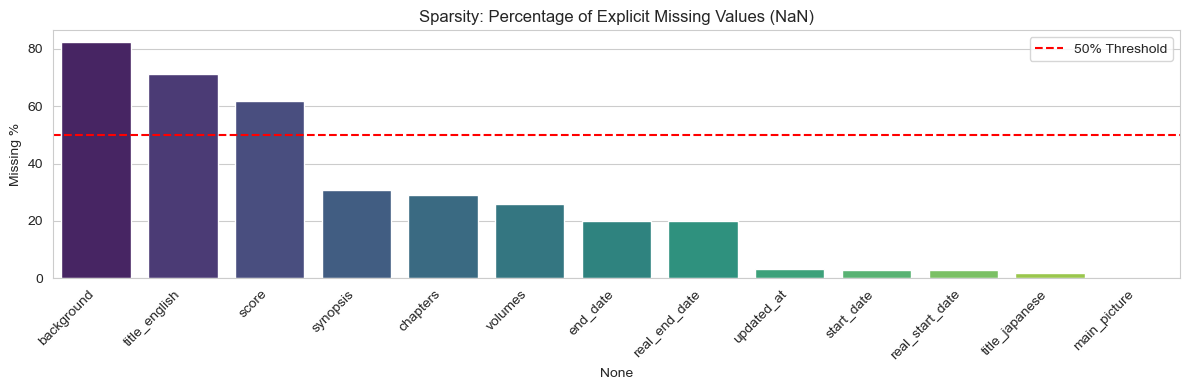

In [237]:
# Visualizing Missingness
plt.figure(figsize=(12, 4))
sns.barplot(x=missing_data.index, y=missing_data.values, hue=missing_data.index, palette="viridis", legend=False)
plt.title("Sparsity: Percentage of Explicit Missing Values (NaN)")
plt.ylabel("Missing %")
plt.axhline(50, color='r', linestyle='--', label='50% Threshold')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

**Observations on Missing Numerical Values**:

*    **Score**: score is missing for ~62% of entries. Standard mean imputation would distort the distribution. We will implement Median Imputation combined with a binary score_missing flag to allow the model to distinguish between "Average Quality" and "Unknown Quality."

*    **Inventory**: chapters (~29%) and volumes (~25%) have significant missingness, likely representing ongoing (publishing) series. We will impute volumes with 1 (minimum viable inventory) for density calculations.

### Missing Values: Categorical Complexity & Hidden Sparsity

In scraped datasets, "Missing Data" is often masked as an empty list string [''] or []. We must audit the list-based features to distinguish between Sparsity (How many are empty?) and Cardinality (How many unique tags exist?).

*    Goal: Determine the encoding strategy for each feature.

        *    High Cardinality (>100): Requires "Top-K" encoding (grouping tail-end values into "Other").

        *    Low Cardinality (<100): Allows for "Frequency Pruning" (keeping all valid tags that appear >N times).

In [238]:
import ast

print("--- Hidden Sparsity Check (Empty Lists '[]') ---")
list_cols = ['genres', 'themes', 'demographics', 'serializations', 'authors']

# Quantify Hidden Sparsity
for col in list_cols:
    empty_count = (manga_df[col] == "[]").sum()
    print(f"{col}: {empty_count} entries ({empty_count/len(manga_df):.2%}) are empty.")

print("\n--- Cardinality Check (Unique Tags) ---")
# We temporarily parse the strings to count distinct categories
def get_cardinality(df, col):
    # Parse string -> list
    temp_series = df[col].dropna().apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    
    # Flatten list
    all_items = []
    for entry in temp_series:
        if not entry: continue
        for item in entry:
            # Handle dicts [{'name': 'Action'}] vs strings ['Action']
            if isinstance(item, dict): all_items.append(item.get('name'))
            else: all_items.append(item)
            
    return len(set(all_items))

for col in list_cols:
    unique_count = get_cardinality(manga_df, col)
    print(f"{col}: {unique_count} unique tags found.")

--- Hidden Sparsity Check (Empty Lists '[]') ---
genres: 2373 entries (3.70%) are empty.
themes: 40093 entries (62.49%) are empty.
demographics: 38144 entries (59.45%) are empty.
serializations: 21199 entries (33.04%) are empty.
authors: 544 entries (0.85%) are empty.

--- Cardinality Check (Unique Tags) ---
genres: 21 unique tags found.
themes: 52 unique tags found.
demographics: 5 unique tags found.
serializations: 1249 unique tags found.
authors: 1 unique tags found.


**Strategic Decisions based on Cardinality:**

*    **Themes (Pruning Strategy):**

        *   Status: High Sparsity (~62% empty) but Low Cardinality (52 unique tags).

        *   Decision: We will use frequency pruning as our strategy. Since there are only 52 themes, we do not need to arbitrarily cap the list. We will retain all themes that appear in at least 50 manga (removing statistical noise) and encode [] as "No_Theme".

*    **Serializations (Top-K Strategy):**

        *   Status: Moderate Sparsity (~33%) but High Cardinality (1249 unique magazines).

        *   Decision: We will use Top-K Encoding (K=80). The "Long Tail" of magazines (those with only 1 published manga) provides negligible predictive signal and will be grouped into "Other_Magazine".

*    **Demographics (One-Hot):**

        *   Status: High Sparsity (~60%) but extremely low cardinality (5 unique).

        *   Decision: Direct One-Hot Encoding, treating [] as "Unknown_Demographic".

## 3.3 Target Variable Analysis (Class Imbalance)
We now examine the distribution of our target variable, `is_adapted`. Understanding the ratio between the positive class (1) and negative class (0) is critical for setting a performance baseline. We will also compare the distribution after we filter only for SFW works.

*    Null Accuracy Baseline: If a model simply predicted "Not Adapted" for every single manga, how accurate would it be? Our machine learning model must exceed this number to be considered useful.

*    Imbalance Ratio: A high ratio (e.g., > 1:10) indicates the need for specialized training techniques.

--- Class Imbalance: Global vs. SFW Scope ---


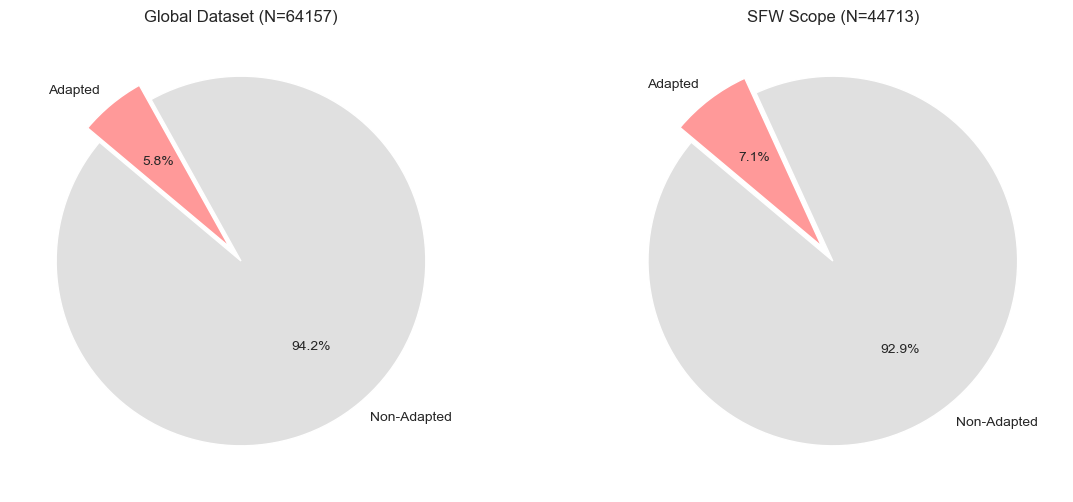

Global Adaptation Rate: 5.80%
SFW Adaptation Rate:    7.06%
Signal Boost:           +1.26%


In [296]:
print("--- Class Imbalance: Global vs. SFW Scope ---")

# Define Color Palette (String Keys)
ADAPTED_COLORS = {'0': '#e0e0e0', '1': '#ff9999',
                  0:'#e0e0e0', 1: '#ff9999'}
colors = [ADAPTED_COLORS['0'], ADAPTED_COLORS['1']]

# Global (Raw)
global_counts = manga_df['is_adapted'].value_counts()
# SFW Only
sfw_counts = manga_df[manga_df['sfw'] == True]['is_adapted'].value_counts()

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot A: Global
axes[0].pie(global_counts, labels=['Non-Adapted', 'Adapted'], autopct='%1.1f%%', 
            colors=colors, explode=(0, 0.1), startangle=140)
axes[0].set_title(f"Global Dataset (N={len(manga_df)})")

# Plot B: SFW Only
axes[1].pie(sfw_counts, labels=['Non-Adapted', 'Adapted'], autopct='%1.1f%%', 
            colors=colors, explode=(0, 0.1), startangle=140)
axes[1].set_title(f"SFW Scope (N={sfw_counts.sum()})")

save_path = os.path.join(img_dir, '01_target_distribution.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

# 4. Metric Comparison
raw_rate = manga_df['is_adapted'].mean()
sfw_rate = manga_df[manga_df['sfw'] == True]['is_adapted'].mean()

print(f"Global Adaptation Rate: {raw_rate:.2%}")
print(f"SFW Adaptation Rate:    {sfw_rate:.2%}")
print(f"Signal Boost:           +{sfw_rate - raw_rate:.2%}")

**Observations:**

*   Strategic Insight: Filtering out NSFW content removes a significant amount of "Noise" (unadapted works). The adaptation rate jumps from 5.8% to ~7.1%.
    
    *   Implication: Our "Null Accuracy" baseline drops from 94.2% to 92.9%. This means the problem is slightly more balanced (easier to find positives) than the raw data suggested, and our model has a clearer target to hit.

*    The 92.9% Baseline: The dataset is still imbalanced. A "dumb" model that predicts 0 for every entry might still achieve 92.90% accuracy.

      *   Strategic Decision: We cannot use Accuracy as our primary evaluation metric, as it will be misleadingly high. We will optimize for F1-Score or Precision-Recall to ensure the model actually learns to identify the minority class.

*    The 1:16 Ratio: For every 1 successful adaptation, there are ~14 unadapted works.

       *   Strategic Decision: We will utilize Stratified K-Fold Cross Validation during the modeling phase. This ensures that every training fold maintains this exact 7.1% ratio, preventing the model from training on a "luckily" balanced subset.

## 3.4 Numerical Distributions & Outliers
We now analyze the relationship between key numerical metrics (score, members) and the target variable. We are looking for separability, whether adapted manga have distinct statistical distributions compared to non-adapted works.

*    Power Law Check: Popularity metrics often follow a Power Law (a few highly successful manga, millions of niche works). We expect members to require Log-Transformation to stabilize the variance.

*    Quality Check: We analyze score to see if adaptations are reserved only for highly-rated works.

--- Distribution Analysis: Adapted vs Non-Adapted ---


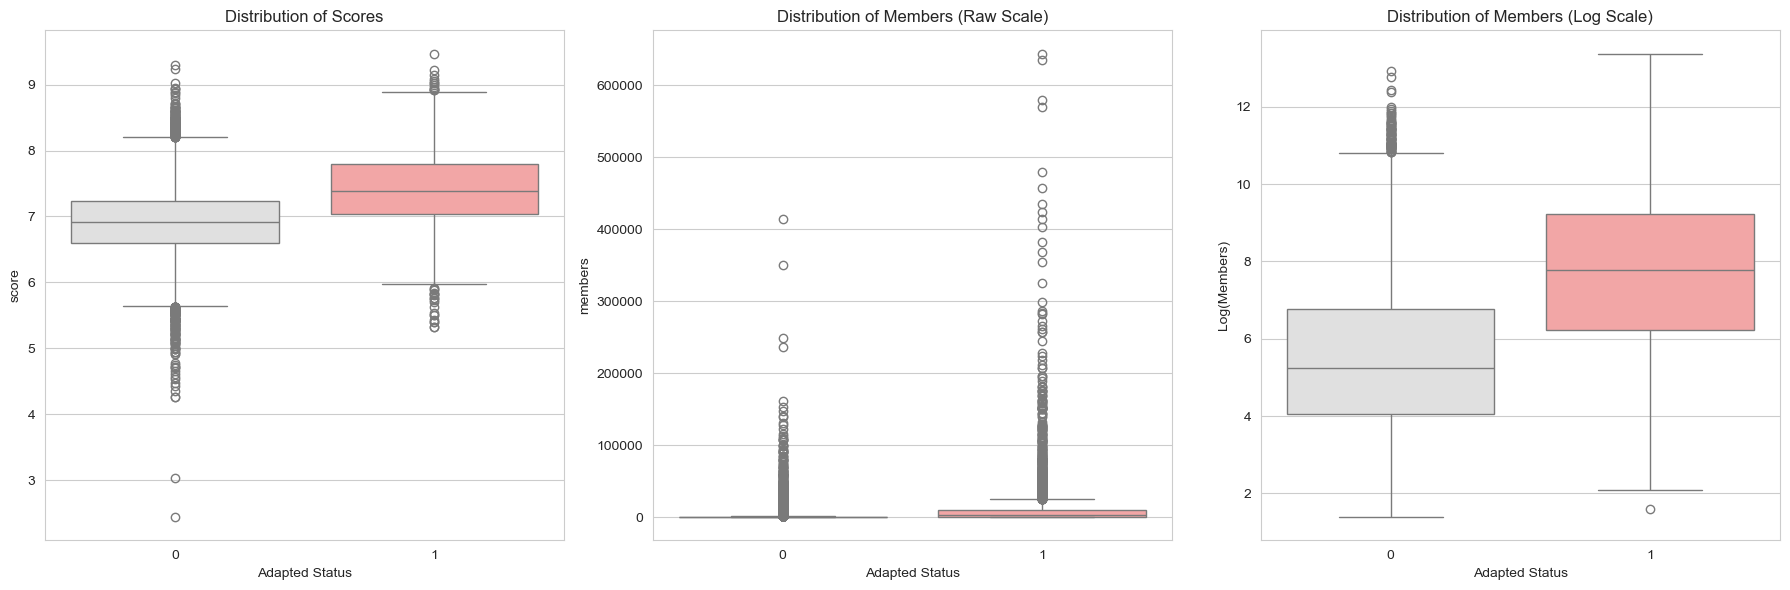

Raw Members Skew: 22.07
Log Members Skew: 0.54


In [297]:
print("--- Distribution Analysis: Adapted vs Non-Adapted ---")

# Create a temporary SFW dataframe for this analysis
sfw_df = manga_df[manga_df['sfw'] == True].copy()
# Create a temporary Log column for visualization purposes
sfw_df['temp_log_members'] = np.log1p(sfw_df['members'])

# Setup Layout: 1 Row, 3 Plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Score Distribution (Boxplot)
sns.boxplot(x='is_adapted', y='score', data=sfw_df, 
            ax=axes[0], palette=ADAPTED_COLORS, hue='is_adapted', legend=False)
axes[0].set_title("Distribution of Scores")
axes[0].set_xlabel("Adapted Status")

# Raw Members Distribution (Boxplot)
sns.boxplot(x='is_adapted', y='members', data=sfw_df, 
            ax=axes[1], palette=ADAPTED_COLORS, hue='is_adapted', legend=False)
axes[1].set_title("Distribution of Members (Raw Scale)")
axes[1].set_xlabel("Adapted Status")

# Log-Members Distribution (Boxplot)
sns.boxplot(x='is_adapted', y='temp_log_members', data=sfw_df, 
            ax=axes[2], palette=ADAPTED_COLORS, hue='is_adapted', legend=False)
axes[2].set_title("Distribution of Members (Log Scale)")
axes[2].set_ylabel("Log(Members)")
axes[2].set_xlabel("Adapted Status")

plt.tight_layout()

save_path = os.path.join(img_dir, '02_log_members_distribution.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

# Quantitative skew check
print(f"Raw Members Skew: {sfw_df['members'].skew():.2f}")
print(f"Log Members Skew: {sfw_df['temp_log_members'].skew():.2f}")

# Clean up
del sfw_df

**Observations**:

1.  The "Popularity" Signal (`members`):

    *   Raw Scale (Middle Plot): The distribution is illegible due to extreme positive skew (Skewness > 20). A few highly successful manga with >100k members compress the rest of the data into a single line.

    *   Log Scale (Right Plot): After transformation, a clear separation emerges. The median "Adapted" manga sits significantly higher on the log-scale than the median "Non-Adapted" manga.

        *   **Decision**: `log_members` is a mandatory feature. Linear models cannot handle the raw distribution.

2. The "Quality" Signal (`score`):

    Overlap: While Adapted manga generally have higher median scores, there is significant overlap. Many high-scoring manga are unadapted (the outliers in the grey box), and some low-scoring manga are adapted.

    **Implication**: Score alone is not a guarantee of adaptation. It must be combined with popularity and genre data to be predictive.

## 3.5 Structural & Inventory Analysis

Beyond popularity and quality, the structure of a work dictates its adaptability.

*    Media Type: We compare Manga (long-form) vs. One-shots (single chapter) vs. Manhwa (Korean).

        *    Hypothesis: One-shots rarely provide enough content for a full season, so their adaptation rate should be near zero.

*    Publishing Status: We compare Finished vs. Publishing.

*    Inventory Size (volumes): We test the "Minimum Content" hypothesis. Does a manga need a minimum number of volumes to be considered for an anime?

In [247]:
# Create SFW View for this section
target_df = manga_df[manga_df['sfw'] == True].copy()

# Create box plot based on adaptation rate by feature
def plot_adaptation_rate(df, col, title, min_threshold=100, save_name=None):
    # Calculate stats
    stats = df.groupby(col)['is_adapted'].agg(['mean', 'count'])
    # Filter rare categories
    stats = stats[stats['count'] > min_threshold].sort_values(by='mean', ascending=False)
    
    plt.figure(figsize=(10, 6)) # Increased size slightly for better readability
    sns.barplot(x=stats.index, y=stats['mean'], palette='viridis', hue=stats.index, legend=False)
    
    # Add Baseline
    global_rate = df['is_adapted'].mean()
    plt.axhline(global_rate, color='red', linestyle='--', label=f'SFW Avg ({global_rate:.1%})')
    
    plt.title(title)
    plt.ylabel("Probability")
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    
    # Save image
    if save_name:
        # Assumes 'img_dir' is defined in your global scope
        save_path = os.path.join(img_dir, save_name)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return stats

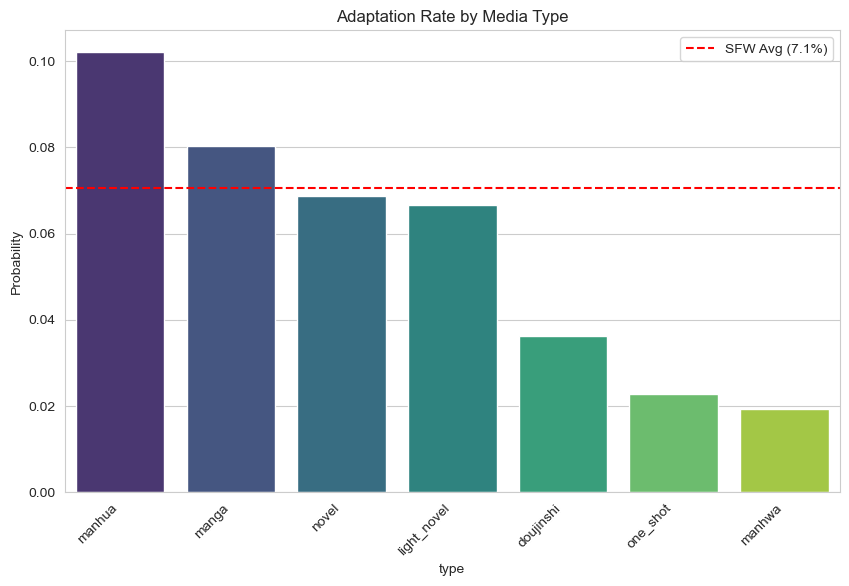

                 mean  count
type                        
manhua       0.102041    343
manga        0.080352  31163
novel        0.068702    131
light_novel  0.066722   7224
doujinshi    0.036304    303
one_shot     0.022735   2903
manhwa       0.019274   2646


In [248]:
# Run for Type
type_stats = plot_adaptation_rate(target_df, 'type', "Adaptation Rate by Media Type", save_name='03_adaptation_mediatype.png')
print(type_stats)

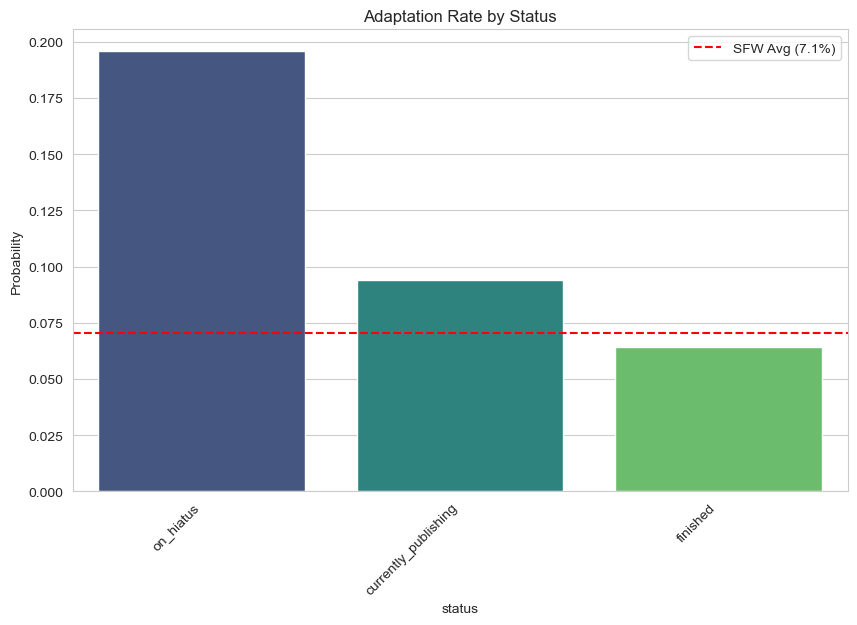

                          mean  count
status                               
on_hiatus             0.195652    184
currently_publishing  0.094168   8591
finished              0.064273  35847


In [249]:
# Run for Status
status_stats = plot_adaptation_rate(target_df, 'status', "Adaptation Rate by Status", save_name='04_adaptation_status.png')
print(status_stats)


--- Volume Inventory Analysis ---


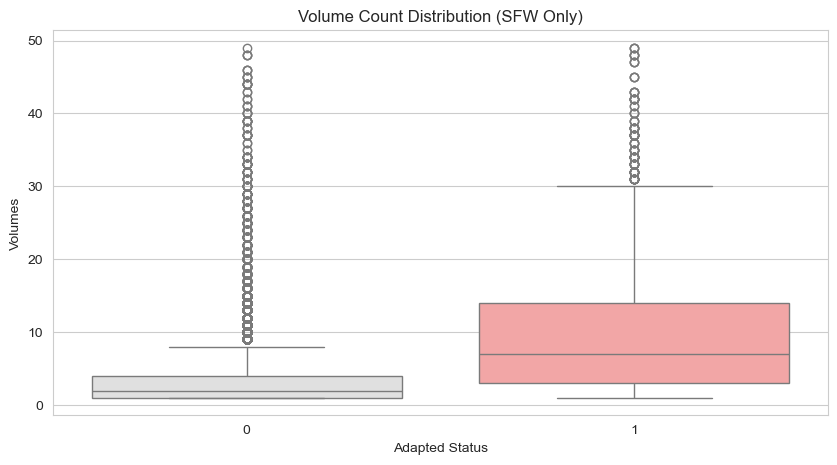

In [302]:
# Run for Inventory (Volumes)
print("\n--- Volume Inventory Analysis ---")
# Boxplot for Mainstream Manga Only (Zoomed in < 50)
plt.figure(figsize=(10, 5))
sns.boxplot(x='is_adapted', y='volumes', data=target_df[target_df['volumes'] < 50], 
            ax=plt.gca(), palette=ADAPTED_COLORS, hue='is_adapted', legend=False)
plt.title("Volume Count Distribution (SFW Only)")
plt.xlabel("Adapted Status")
plt.ylabel("Volumes")
save_path = os.path.join(img_dir, '05_volume_distribution.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

In [245]:
# "Minimum Viable Product" Calculation
adapted_vols = target_df[target_df['is_adapted'] == 1]['volumes']
print(f"Median Length of Adapted Series: {adapted_vols.median()} volumes")
print(f"Minimum Viable Length (5th Percentile): {adapted_vols.quantile(0.05)} volumes")

Median Length of Adapted Series: 7.0 volumes
Minimum Viable Length (5th Percentile): 1.0 volumes


**Observations**

1. Format

    *   Manga vs. Short Form: Serialized Manga has a healthy adaptation rate of 8.03%. In contrast, One-shots sit at just 2.27%.

          *    Insight: One-shots operate as "pilots". While they can be adapted, they usually become a serialized manga first before getting an anime. Treating them as equal to full series introduces noise.

    *   Non-Japanese Formats: While Manhua (Chinese) shows a high rate (10.2%), the sample size is tiny (343 vs 31k Manga), indicating selection bias (only highly successful manhua are imported to MyAnimeList). Manhwa (Korean) is very low (1.9%).

        *   Decision: To maintain a consistent market context (the Japanese Production Committee system), we will filter the dataset to keep only Manga and Light Novels.

2. Publishing Status (The "Hiatus" anomaly):

    *    Hiatus: Surprisingly, series On Hiatus have the highest adaptation rate (~19%).

          *    Interpretation: High-profile manga often go on hiatus due to health issues from the workload of success, or the anime catches up to the source material (causing a hiatus). This is likely a correlation, not a cause.

    *   Publishing vs. Finished: Currently Publishing series (9.4%) are more likely to be adapted than Finished ones (6.4%). This confirms the industry preference for "Active Hype"—studios want to adapt works while they are still on store shelves.

3. Inventory Requirements:

    *    The "7-Volume" Standard: After removing NSFW content, the median inventory for an adapted series rose to 7 volumes.

    *    Minimum Viable Product: The 5th percentile remains at 1 volume (likely movies/OVAs), but the distribution clearly shifts right for adaptations.

            *    Decision: `volumes` and `members_per_volume` are confirmed as high-quality signals.

## 3.6 Content Analysis (Genres, Themes, Demographics)

We analyze which content categories are statistically "Over-Indexed" for adaptation.

*    Scope Control: To ensure these insights apply to the mainstream market, we apply a Temporary SFW Filter, excluding Hentai and Erotica.

*    Granularity: We visualize categories with >50 works to uncover niche but high-signal themes that would be hidden by a strict "Top 10" filter.

In [250]:
# Function to plot categories
def plot_content_performance(df, col_name, top_n=30, min_count=50, save_name=None):
    """
    Plots adaptation rate for categories.
    FILTERS:
    1. SFW Only (Commercial Market focus)
    2. 'Award Winning' Removal (Leakage focus)
    """
    # SCOPE FILTER (SFW)
    target_df = df[df['sfw'] == True][[col_name, 'is_adapted']].dropna()
    
    # Parsing
    if isinstance(target_df[col_name].iloc[0], str):
        import ast
        target_df[col_name] = target_df[col_name].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])
        
    # Explode List Columns
    exploded = target_df.explode(col_name)
    
    def get_name(val):
        if isinstance(val, dict): return val.get('name')
        return val
    exploded[col_name] = exploded[col_name].apply(get_name)
    
    # Remove "Award Winning" as it is a post-hoc label
    exploded = exploded[exploded[col_name] != 'Award Winning']
    
    # Aggregation
    stats = exploded.groupby(col_name)['is_adapted'].agg(['mean', 'count'])
    
    # Filter Noise
    stats = stats[stats['count'] > min_count]
    
    # Plotting
    top_stats = stats.sort_values(by='mean', ascending=False).head(top_n)
    
    plt.figure(figsize=(14, 6))
    sns.barplot(x=top_stats.index, y=top_stats['mean'], palette='magma', hue=top_stats.index, legend=False)
    
    # Add Baseline
    baseline = target_df['is_adapted'].mean()
    plt.axhline(baseline, color='red', linestyle='--', label=f'SFW Baseline ({baseline:.1%})')
    
    plt.title(f"Adaptation Probability by {col_name.capitalize()} (SFW Only, No Awards)")
    plt.ylabel("Probability")
    plt.xticks(rotation=45, ha='right')
    plt.legend()

    if save_name:
        # Assumes 'img_dir' is defined in your global scope
        save_path = os.path.join(img_dir, save_name)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()


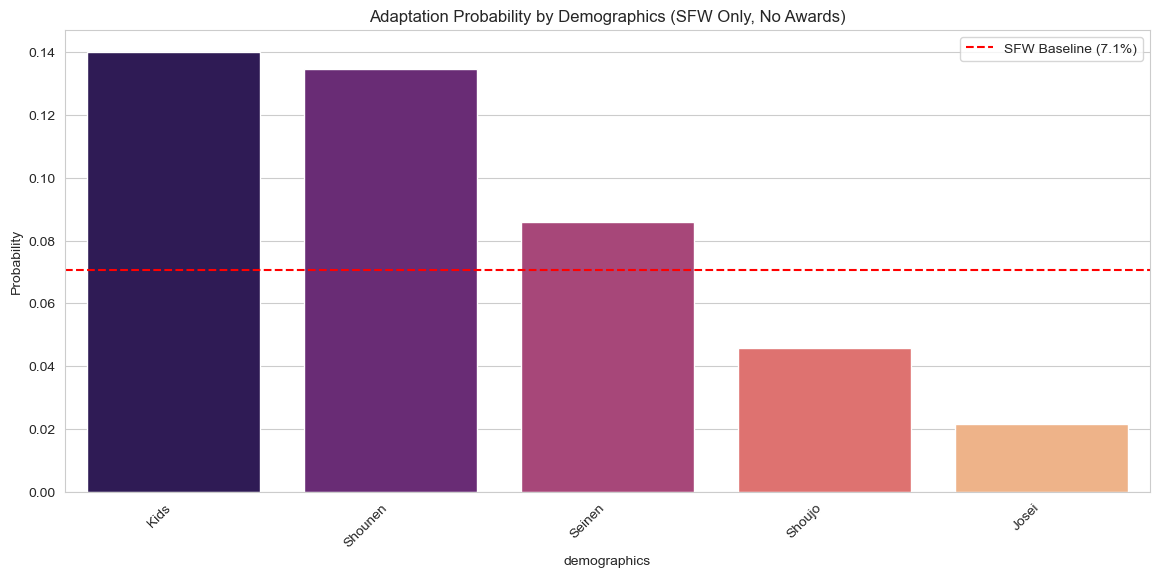

In [251]:
# Demographics Bar Plot
plot_content_performance(manga_df, 'demographics', top_n=10, min_count=50, save_name='06_adaptation_demographic')

**Observations on Demographics**

The demographics plot reveals a distinct "Commercial Hierarchy" in the manga industry.

*    **Dominance of Young Male & Kids Demographics**: Kids (14.0%) and Shounen (13.5%) are the are the demographics adapted at the highest rate. Their adaptation rates are nearly double the baseline.

        *    Insight: This aligns with industry logic; these demographics drive the highest merchandise sales (toys, games) and long-running franchises (e.g., One Piece, Doraemon), making them safer investments for production committees.

*    **Seinen Middle Ground**: Seinen (8.5%) performs modestly above the baseline

        *    Insight: While often critically acclaimed, these series typically feature more mature, complex themes that may limit their broadcast timeslots or merchandising potential compared to Shounen.

*    **Shojo/Josei Gap**: Shoujo (4.5%) and Josei (2.1%) significantly underperform.

        *   Insight: Despite a dedicated readership, female-targeted manga are statistically less likely to be adapted than their male-targeted counterparts. Josei, specifically (targeted at adult women), has the lowest adaptation probability, suggesting it is viewed as a high-risk niche in the animation sector.

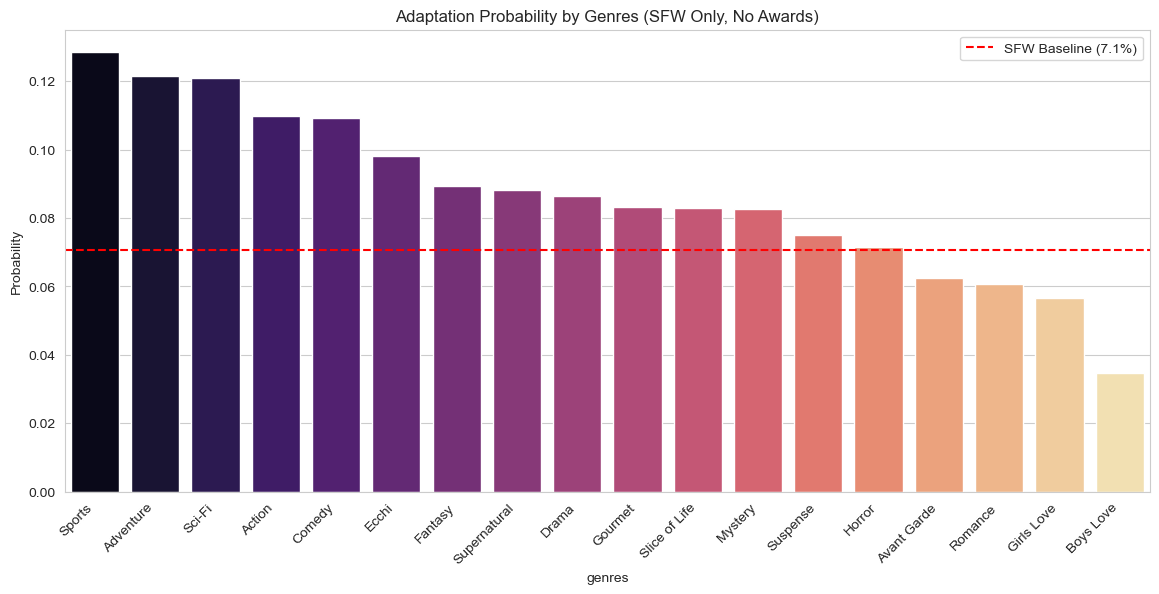

In [252]:
# Genre Bar Plot
plot_content_performance(manga_df, 'genres', top_n=25, min_count=50, save_name='07_adaptation_genres')

**Observations on Genres**

The genre analysis highlights a preference for "High Visual Impact" and "Escapist" storytelling.

*    **Top Performers (High Adaptation Probability):**

        *    Sports (~12.8%) and Adventure/Sci-Fi (~12.1%): These top the list. Sports series are staples of anime due to their ability to fill long broadcast schedules and sell team-based merchandise. Adventure and Sci-Fi benefit from the medium of animation, which can depict worlds impossible to film in live-action.

        *    Action & Comedy: Consistently high performers that sit comfortably above the 10% mark.

*    **The "Ecchi" Factor:**

        *    Ecchi (~9.8%) performs significantly above the baseline. This confirms that fan-service-oriented content remains a viable, consistent commercial strategy for adaptations, likely due to strong Blu-ray/DVD sales potential.

*    **The "Average" Zone:**

        *    Drama, Gourmet, Slice of Life, Mystery: These hover just above the 7.1% baseline. They are reliable filler for seasonal lineups but are not the primary drivers of the industry.

*    **Underperformers (Below Baseline):**

        *    Romance (~6.0%): Surprisingly, Romance falls below the average adaptation rate. This suggests that while popular, the market is oversaturated with manga in this genre, making the competition for adaptation fierce.

        *    Niche Interests (Avant Garde, BL/GL): Avant Garde, Girls Love, and Boys Love are among the lowest probabilities. These are generally considered niche markets with smaller potential returns on investment compared to mass-market Action or Adventure.

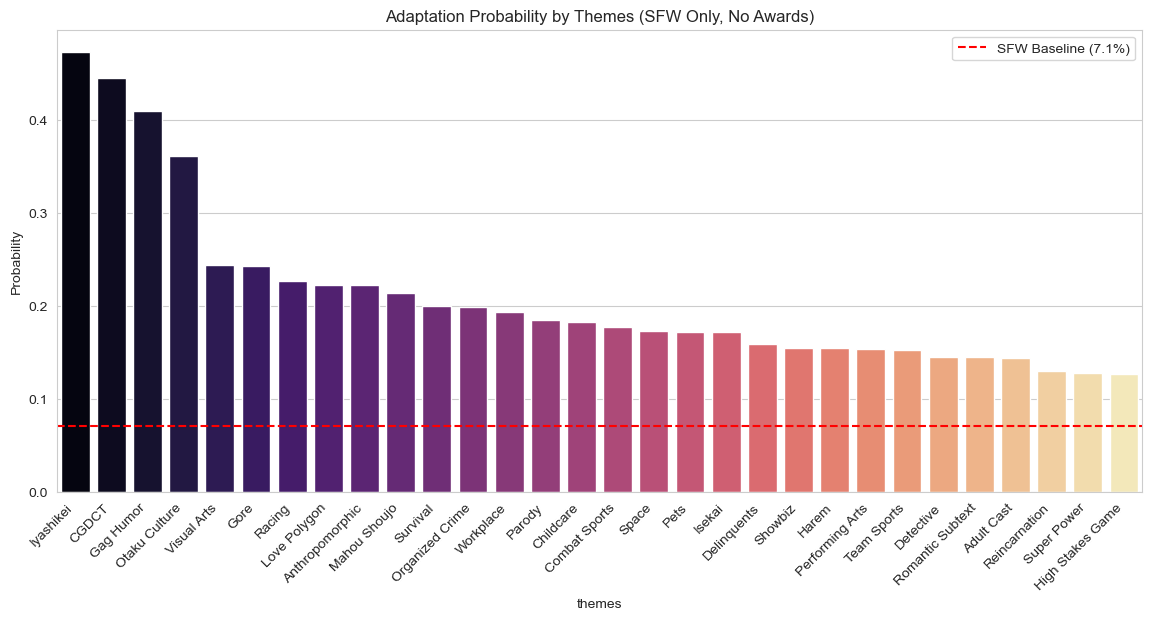

In [253]:
# Themes Bar Plot
plot_content_performance(manga_df, 'themes', top_n=30, min_count=50, save_name='08_adaptation_themes')

**Observation on Themes**

The "Themes" plot provides the most dramatic insights of the entire analysis. While broad genres topped out at ~12% adaptation probability, specific themes reach as high as 45%+. This suggests that specificity is a key driver for adaptation.

*    The Dominance of "Comfort" & Otaku Culture:

        *    Iyashikei (Healing) (~48%) and CGDCT (Cute Girls Doing Cute Things) (~44%) are statistically the safest bets in the entire industry. Nearly half of all SFW manga tagged with "Iyashikei" receive adaptations.

        *    Insight: These themes often overlap with "Slice of Life" (which had a low ~8% rating as a broad genre). This proves that generic Slice of Life is risky, but targeted Slice of Life (Healing/Cute) is adaptation gold, likely due to lower animation budget requirements and high merchandise potential (figures/character goods).

*    Comedy & Niche Interest:

        *    Gag Humor (~40%) and Otaku Culture (~35%) show incredible performance. "Gag Humor" often implies 4-panel (4-koma) manga, which are cost-effective to adapt into short-form anime.

*    Visual & High-Stakes Niches:

        *    Visual Arts, Gore, and Racing sit in the 20-30% range. These are "spectacle" themes that benefit most from the shift to animation (movement, color, sound), making them attractive projects for studios looking to showcase technical skill.

*    The "Isekai" Reality:

        *    Isekai appears in the middle tier (~17%). While popular, its adaptation rate is lower than Iyashikei. This likely reflects market saturation—there are simply too many Isekai manga being produced, lowering the statistical probability of any single one being adapted, despite the genre's overall popularity.



## 3.7 Temporal Analysis: Right-Censoring & Time-to-Event

We need to identify the "Lag Time" of the industry. Adaptation is not instantaneous; it takes years of serialization to build the catalogue required for an anime.

Goal: Find the exact year where the adaptation rate artificially crashes. This will be our training data cut-off.

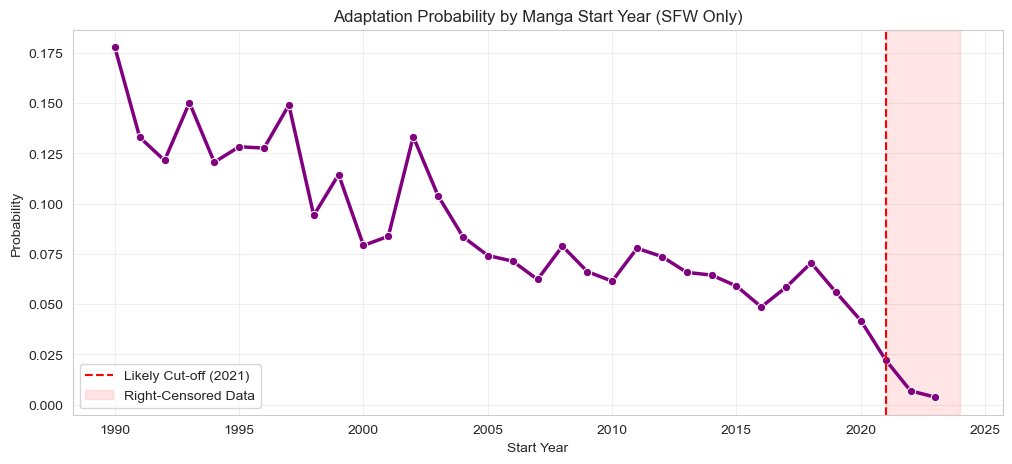

In [309]:
# Prepare Data (SFW Only for consistency)
time_df = manga_df[manga_df['sfw'] == True].copy()

# Extract Year
# errors='coerce' handles invalid dates by turning them into NaT (Not a Time)
time_df['start_year'] = pd.to_datetime(time_df['start_date'], errors='coerce').dt.year

# 3Aggregate Adaptation Rate by Year
# We focus on the modern era (1990-2024) to keep the chart readable
yearly_stats = time_df.groupby('start_year')['is_adapted'].mean()
yearly_stats = yearly_stats.loc[1990:2024] 

# Visualization
plt.figure(figsize=(12, 5))
sns.lineplot(x=yearly_stats.index, y=yearly_stats.values, marker="o", color="purple", linewidth=2.5)

# Add visual markers for the decision boundary
plt.axvline(x=2021, color='red', linestyle='--', label='Likely Cut-off (2021)')
plt.axvspan(2021, 2024, color='red', alpha=0.1, label='Right-Censored Data')

plt.title("Adaptation Probability by Manga Start Year (SFW Only)")
plt.ylabel("Probability")
plt.xlabel("Start Year")
plt.legend()
plt.grid(True, alpha=0.3)

save_path = os.path.join(img_dir, '09_adaptation_startyear.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
plt.show()

**Observations**
1. Right-Censoring (2021–Present):
The graph shows a drastic drop in adaptation probability starting around 2021, approaching 0% in 2023/2024.

    *    Definition: These data points are right-censored because the observation window is shorter than the typical time required for the event to occur.

    *    Mechanism: The industry process—gaining popularity, committee formation, and production—creates a natural latency period (typically 2–4 years).

    *    Implication: For series started after 2020, the variable is_adapted effectively represents "Adapted Fast," not "Adapted at All." Including these years would introduce significant noise and false negatives into the model.

2. Survivorship Bias (1990–2010): The data from 1990 to roughly 2005 shows an unusually high adaptation rate (peaking near 18%).

    *    Selection Bias: This likely indicates Survivorship Bias in the database collection. Older manga that were not adapted and not popular are less likely to be archived in modern databases compared to successful franchises from the same era.

    *    Consequence: The "baseline" adaptation rate for the 90s appears artificially inflated compared to the more complete data of the 2010s.

3. The Stable Period (2010–2018): Between 2010 and 2018, the adaptation rate stabilizes between 5% and 8%.

    *    This period likely represents the most accurate "true positive" rate for the industry, as the database is complete enough to capture non-adapted failures, and enough time has passed to minimize censoring issues.

## 3.8 Multicollinearity Check

We verify if our popularity metrics are redundant.

*    Hypothesis: members (people who added it to their list) and scored_by (people who actually wrote a score) capture the same underlying signal: "Popularity."

*    Threshold: If the correlation coefficient (R) between two features is > 0.95, they are effectively collinear. We should drop one to reduce model complexity.

--- Correlation Matrix (Popularity Signals) ---


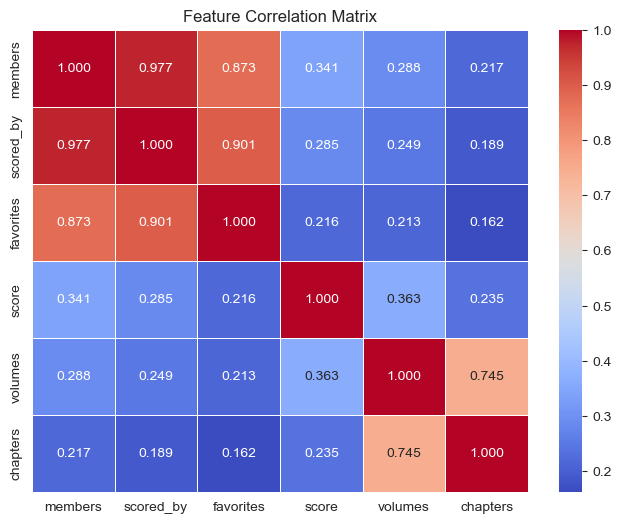

In [251]:
print("--- Correlation Matrix (Popularity Signals) ---")

# We include 'score' to see if popularity correlates with quality
corr_cols = ['members', 'scored_by', 'favorites', 'score', 'volumes', 'chapters']
corr_matrix = manga_df[corr_cols].corr()

# Visualize
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".3f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

**Multicollinearity Observations**

**1. Popularity Redundancy (The "Red" Block):**
* **Finding:** `members` and `scored_by` exhibit near-perfect correlation ($R \approx 0.98$).
* **Implication:** These two features capture the exact same signal. Including both introduces multicollinearity, which inflates standard errors in linear models.
* **Decision:** We will **DROP** `scored_by` and `favorites`. We retain `members` as our primary popularity metric because it represents the widest "interest funnel" (including users who plan to read but haven't scored yet).

**2. Inventory Signals (The "Orange" Block):**
* **Finding:** `volumes` and `chapters` have a strong but not perfect correlation ($R \approx 0.75$).
* **Decision:** We will **DROP** `chapters` and retain `volumes`.
* **Rationale:** While statistically distinct, `volumes` is the industry-standard metric for adaptation viability (e.g., "Enough material for 3 tankobon volumes"). `chapters` is often noisy due to varying chapter lengths (e.g., 4-koma vs. monthly serialization).

**3. Signal Independence:**
* **Finding:** `score` and `members` have a low correlation ($R \approx 0.34$).
* **Conclusion:** Quality and Popularity are independent drivers. A high score does not guarantee popularity, and vice-versa. Both features are necessary for the model.

## 3.9 EDA Conclusions & Action Plan

**Impact on Modeling Strategy**

*   Class Imbalance (1:14 Ratio)	

    *   Metric: We cannot use Accuracy (Baseline 92.9%). We must optimize for F1-Score or PR-AUC.

    *   Technique: Models must use Class Weights (scale_pos_weight) or we must use Stratified K-Fold validation to preserve the minority class.

*   High Dimensionality (~150 Features)	

     *   The feature set will be sparse (mostly 0s) due to One-Hot Encoding of genres/magazines.

     *   Model Choice: Tree-based models (XGBoost, LightGBM) are preferred as they handle sparsity and non-linearity natively.

     *   Regularization: If using Logistic Regression, L1 (Lasso) regularization is required to zero out irrelevant noise.

*   Non-Linear Separability	

    *   The "Score" and "Members" boxplots showed significant overlap between classes.

     *   Insight: A simple linear boundary (Linear SVC) will likely underfit. We need non-linear algorithms (Random Forest, Gradient Boosting) to capture complex interactions (e.g., Low Score but High Isekai count = Adapted).

# 4. Feature Engineering

## 4.1 Scope Control & Row Filtering

We begin by filtering the dataset to match the Commercial Mainstream Market defined in our EDA.

*    **Format Filter**: We restrict analysis to Manga and Light Novels. We exclude One-shots (2.2% adaptation rate) and Manhua/Manhwa to maintain a consistent production context (Japanese serialization incentives).

*    **Content Filter**: We strictly exclude sfw=False (Hentai/Erotica) as they operate on different market dynamics (OVA vs. TV).

*    **Temporal Filter**: We drop all series starting in 2021 or later to prevent Look-Ahead Bias

In [252]:
print("---  Filtering Scope ---")
initial_count = len(manga_df)

# Define Valid Formats
valid_types = ['manga', 'light_novel']

# Apply Filters (SFW + Format)
manga_clean = manga_df[
    (manga_df['sfw'] == True) & 
    (manga_df['type'].isin(valid_types))
].copy()

# Apply Temporal Filter (Pre-2021)
manga_clean['start_year'] = pd.to_datetime(manga_clean['start_date'], errors='coerce').dt.year
manga_clean = manga_clean[manga_clean['start_year'] < 2021]

# VALIDATION
dropped_count = initial_count - len(manga_clean)
print(f"Original Rows: {initial_count}")
print(f"Remaining Rows: {len(manga_clean)}")
print(f"Dropped: {dropped_count} entries ({dropped_count/initial_count:.1%} of data)")
print(f"Unique Types Remaining: {manga_clean['type'].unique()}")

---  Filtering Scope ---
Original Rows: 64157
Remaining Rows: 34896
Dropped: 29261 entries (45.6% of data)
Unique Types Remaining: ['manga' 'light_novel']


## 4.2 List Parsing

The raw data stores lists as strings (e.g., "['Action', 'Comedy']"). We must parse these into actual Python objects to enable One-Hot Encoding later.

In [253]:
print("\n--- Parsing Stringified Lists ---")
list_cols = ['genres', 'themes', 'demographics', 'serializations']

def safe_literal_eval(val):
    """Safely converts string representations to actual Python lists."""
    if pd.isna(val) or val == "": 
        return []
    try: 
        return ast.literal_eval(val)
    except (ValueError, SyntaxError): 
        return []

for col in list_cols:
    manga_clean[col] = manga_clean[col].apply(safe_literal_eval)

# VALIDATION
# Check the first row to ensure it's a list, not a string
sample_val = manga_clean['genres'].iloc[0]
print(f"Sample Genre Entry: {sample_val}")
print(f"Entry Type: {type(sample_val)}") # Should be <class 'list'>


--- Parsing Stringified Lists ---
Sample Genre Entry: ['Action', 'Adventure', 'Award Winning', 'Drama', 'Fantasy', 'Horror', 'Supernatural']
Entry Type: <class 'list'>


## 4.3 Numerical Feature Engineering

We address the distribution issues found in Section 3.4 (Outliers & Missingness).

*    **Log Transformation**: We create log_members to normalize the "Power Law" distribution of popularity.

*    **Density Metric**: We create members_per_vol to identify "Dense" hits (high popularity with few volumes).

*    **Score Imputation**: We fill the 60% missing scores with the Median. We create a binary flag score_missing so the model treats imputed scores differently from real "average" scores.

In [254]:
print("\n--- Numerical Transformations ---")

# 1. Log-Transform Members
manga_clean['log_members'] = np.log1p(manga_clean['members'])

# 2. Impute Volumes (The Fix)
# We permanently fill NaNs with 1 in the main dataframe
manga_clean['volumes'] = manga_clean['volumes'].fillna(1).replace(0, 1)

# 3. Density Metric
# Now we can safely divide using the fixed column
manga_clean['members_per_vol'] = manga_clean['members'] / manga_clean['volumes']

# 4. Impute Score
median_score = manga_clean['score'].median()
manga_clean['score_missing'] = manga_clean['score'].isna().astype(int)
manga_clean['score'] = manga_clean['score'].fillna(median_score)

# VALIDATION
print(f"Median Score Used: {median_score}")
print("Check for NaNs in numerical columns:")
print(manga_clean[['log_members', 'members_per_vol', 'score', 'volumes']].isna().sum())


--- Numerical Transformations ---
Median Score Used: 7.02
Check for NaNs in numerical columns:
log_members        0
members_per_vol    0
score              0
volumes            0
dtype: int64


## 4.4 Categorical Encoding

We apply three distinct strategies based on cardinality (EDA Section 3.1):

*    Top-K Encoding (serializations): There are >1,000 magazines. We keep the Top 80 and group the rest into "Other_Magazine".

*    Frequency Pruning (genres, themes): We explode the lists and create binary columns for any tag appearing >50 times.

     *    Leakage Control: We explicitly remove the "Award Winning" tag.

*    One-Hot Encoding (type, demographics): Low cardinality allows direct binary encoding.

*Note: For this analysis, I utilized pandas get_dummies for efficient one-hot encoding and dimensionality reduction (filtering for top-k genres). In a production environment where the model encounters unseen categories in real-time, sklearn.OneHotEncoder(handle_unknown='ignore') would be the preferred architectural choice to prevent pipeline breakage.*

In [255]:
print("\n--- Categorical Encoding ---")

# A. Magazine Grouping (Top 80 Strategy)
all_mags = []
for sublist in manga_clean['serializations']:
    for item in sublist:
        if isinstance(item, dict): all_mags.append(item.get('name'))
        else: all_mags.append(item)

# Identify Top 80
top_mags = pd.Series(all_mags).value_counts().head(80).index.tolist()

def get_magazine_group(mag_list):
    if not mag_list: return "Indie/None"
    first = mag_list[0]
    name = first.get('name') if isinstance(first, dict) else str(first)
    return name if name in top_mags else "Other_Magazine"

manga_clean['magazine'] = manga_clean['serializations'].apply(get_magazine_group)

# B. Multi-Label Encoding Function (Pruning)
def encode_multilabel(df, col, min_count=50, prefix=""):
    # Flatten and Count
    all_tags = []
    for sublist in df[col]:
        for item in sublist:
            name = item.get('name') if isinstance(item, dict) else item
            all_tags.append(name)
            
    # Filter by Frequency
    tag_counts = pd.Series(all_tags).value_counts()
    valid_tags = tag_counts[tag_counts > min_count].index.tolist()
    
    # LEAKAGE REMOVAL
    if "Award Winning" in valid_tags: 
        valid_tags.remove("Award Winning")
        print(f"[{col}] Removed 'Award Winning' to prevent leakage.")
    
    print(f"[{col}] Kept {len(valid_tags)} tags (freq > {min_count})")
    
    # Create Binary Columns
    for tag in valid_tags:
        col_name = f"{prefix}{tag}"
        df[col_name] = df[col].apply(lambda x: 1 if any((i.get('name') if isinstance(i, dict) else i) == tag for i in x) else 0)
    return df

# Apply Encodings
manga_clean = encode_multilabel(manga_clean, 'genres', min_count=50, prefix="genre_")
manga_clean = encode_multilabel(manga_clean, 'themes', min_count=50, prefix="theme_")
manga_clean = encode_multilabel(manga_clean, 'demographics', min_count=10, prefix="demo_")

# C. One-Hot Encoding (Magazines & Type)
manga_clean = pd.get_dummies(manga_clean, columns=['type', 'magazine'], prefix=['type', 'mag'], dummy_na=False)

# VALIDATION
print(f"New Shape: {manga_clean.shape}")
print(f"Magazines Created: {[c for c in manga_clean.columns if 'mag_' in c][:5]} ...")


--- Categorical Encoding ---
[genres] Removed 'Award Winning' to prevent leakage.
[genres] Kept 18 tags (freq > 50)
[themes] Kept 48 tags (freq > 50)
[demographics] Kept 5 tags (freq > 10)
New Shape: (34896, 189)
Magazines Created: ['mag_ARIA', 'mag_Afternoon', 'mag_AlphaPolis Web Manga', 'mag_Asuka', 'mag_Bessatsu Friend'] ...


## 4.5 Final Cleanup & Dataset Export

We drop the raw text columns and redundant features identified in EDA Section 3.8 (scored_by, chapters). The final dataset model_df contains only numerical and binary data, ready for ingestion by Scikit-Learn.

In [256]:
# ==========================================
# 4.5 CLEANUP & EXPORT
# ==========================================

print("\n--- Step 5: Final Cleanup ---")

# Define Drop List
cols_to_drop = [
    # Metadata
    'manga_id', 'title', 'title_english', 'title_japanese', 'title_synonyms', 'url', 'main_picture',
    'start_date', 'end_date', 'real_start_date', 'real_end_date', 'start_year',
    'approved', 'created_at_before', 'updated_at', 'background', 'synopsis', 'sfw',
    # Redundant/Processed
    'scored_by', 'favorites', 'chapters', 'status', 'authors', 
    'genres', 'themes', 'demographics', 'serializations'
]

# Execute Drop
existing_drops = [c for c in cols_to_drop if c in manga_clean.columns]
model_df = manga_clean.drop(columns=existing_drops)

# FINAL VALIDATION
print(f"Final Matrix Shape: {model_df.shape}")
print(f"Target 'is_adapted' exists: {'is_adapted' in model_df.columns}")
print(f"Any NaN remaining: {model_df.isna().sum().sum()}")


--- Step 5: Final Cleanup ---
Final Matrix Shape: (34896, 162)
Target 'is_adapted' exists: True
Any NaN remaining: 0


In [260]:
# ==========================================
# DIAGNOSTIC: FINAL DATA HEALTH CHECK
# ==========================================
import numpy as np

print("--- 1. Missing Value Audit ---")
nan_counts = model_df.isna().sum()
total_nans = nan_counts.sum()

if total_nans == 0:
    print("✅ SUCCESS: No missing values found.")
else:
    print(f"❌ ERROR: Found {total_nans} missing values!")
    print(nan_counts[nan_counts > 0])
    # Correction Hint: If 'volumes' is here, re-run Block 3 Fix.

print("\n--- 2. Data Type Audit ---")
# Everything must be int, float, or uint8 (for booleans)
# We check if there are any 'object' columns left (strings/lists)
non_numeric = model_df.select_dtypes(include=['object']).columns

if len(non_numeric) == 0:
    print("✅ SUCCESS: All columns are numerical.")
else:
    print(f"❌ ERROR: Found non-numeric columns: {non_numeric.tolist()}")
    # Correction Hint: If 'magazine' is here, Block 4 One-Hot encoding failed.

print("\n--- 3. Target Variable Audit ---")
if 'is_adapted' in model_df.columns:
    unique_vals = model_df['is_adapted'].unique()
    print(f"✅ Target 'is_adapted' found. Unique values: {unique_vals}")
    if len(unique_vals) != 2:
        print("⚠️ WARNING: Target variable does not look binary (0/1). Check filters.")
else:
    print("❌ ERROR: Target variable 'is_adapted' is MISSING!")

print("\n--- 4. Shape & Sparsity ---")
rows, cols = model_df.shape
print(f"Final Matrix: {rows} rows x {cols} columns")

# Check Sparsity (Ratio of Zeros)
# High sparsity is expected due to One-Hot Encoding
sparsity = (model_df == 0).sum().sum() / (rows * cols)
print(f"Matrix Sparsity: {sparsity:.1%} (Normal for One-Hot data)")

--- 1. Missing Value Audit ---
✅ SUCCESS: No missing values found.

--- 2. Data Type Audit ---
✅ SUCCESS: All columns are numerical.

--- 3. Target Variable Audit ---
✅ Target 'is_adapted' found. Unique values: [1 0]

--- 4. Shape & Sparsity ---
Final Matrix: 34896 rows x 162 columns
Matrix Sparsity: 93.3% (Normal for One-Hot data)


In [254]:
# ==========================================
# END OF SECTION 4: SAVE CHECKPOINT
# ==========================================

# Define filename
processed_path = os.path.join(processed_dir, 'manga_model_data.csv')

# Save the cleaned and data engineered dataframe
model_df.to_csv(processed_path, index=False)

print(f"Checkpoint saved")
print("Section 4 Complete.")

Checkpoint saved
Section 4 Complete.


# 5. Modeling

**The Models**

*    **Baseline (Decision Tree)**: A single tree represents simple, interpretable rules

*    **Regularized (Lasso Regression)**: We use L1 Regularization to perform automatic feature selection. This tests the hypothesis that our ~150 One-Hot features contain noise that should be zeroed out.

      *    Hyperparameter: C=0.2 (Inverse regularization strength). A low C forces more coefficients to zero.

      *    Why it was useful: Our dataset contained over 150 features due to One-Hot Encoding (Magazines, Genres). Many of these were sparse and noisy. Using Lasso (L1) regularization allowed us to perform automatic feature selection.

*    **Random Forest**: This model uses Bootstrap Aggregating to build hundreds of decorrelated decision trees, capturing non-linear interactions (e.g., "High score is good, but only if the genre is NOT Hentai").

     *    How it works: Random Forest constructs multiple decision trees during training. Each tree sees a random subset of the data and features (bagging). The final prediction is the "vote" of the majority of trees, which reduces the risk of overfitting compared to a single decision tree.

     *    Strengths: It captures non-linear relationships (e.g., Conditional Logic) and is robust to outliers. It does not require feature scaling. It excels in high-dimensional datasets with categorical features (like our Genre tags) where complex interactions define the target.



## 5.1 Setup Models

In [286]:
print("--- 5.1 Setup ---")
# 1. Prepare Data
# Ensure we drop the target from X
if 'is_adapted' in model_df.columns:
    X = model_df.drop(columns=['is_adapted'])
    y = model_df['is_adapted']
else:
    print("CRITICAL ERROR: 'is_adapted' missing from model_df. Re-run Section 4.")

# 2. Define Validation Scheme
# Stratified K-Fold ensures every split has the same ~7% adaptation rate
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3. Define Model Architectures (Pipelines)
models = {
    "Baseline (Decision Tree)": Pipeline([
        ('clf', DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42))
    ]),
    
    "Regularized (Lasso)": Pipeline([
        ('scaler', StandardScaler()), 
        # C=0.2: Moderate regularization strength (Lower C = Stronger penalty)
        # penalty='l1': Forces coefficients to zero (Feature Selection)
        # solver='liblinear': Required for L1 penalty
        ('clf', LogisticRegression(penalty='l1', C=0.2, solver='liblinear', class_weight='balanced', random_state=42))
    ]),
    
    "Tree (Random Forest)": Pipeline([
        # Trees do NOT need scaling, so we skip StandardScaler to keep features raw/interpretable
        ('clf', RandomForestClassifier(n_estimators=100, max_depth=8, class_weight='balanced', random_state=42))
    ])
}

print(f"Data Shape: {X.shape}")
print(f"Validation Scheme: Stratified K-Fold (k=5)")

--- 5.1 Setup ---
Data Shape: (34896, 161)
Validation Scheme: Stratified K-Fold (k=5)


## 5.2 Cross Validation

**Validation Strategy**

*    Stratified K-Fold (k=5): We use stratification to ensure every fold maintains the exact ~7.1% adaptation rate.

*    Metrics: We report Mean F1-Score, Precision, Recall, and ROC-AUC to confirm model robustness across folds.

In [ ]:
# Cross Validation Loop and Show Scores
results = []
scoring_metrics = ['f1', 'precision', 'recall', 'roc_auc', 'accuracy']

for name, pipeline in models.items():
    print(f"Running {name}...")

    # Run Cross-Validation
    cv_results = cross_validate(pipeline, X, y, cv=cv, scoring=scoring_metrics, n_jobs=-1)

    results.append({
        "Model": name,
        "F1 (Mean)": cv_results['test_f1'].mean(),
        "F1 (Std)": cv_results['test_f1'].std(),
        "Precision": cv_results['test_precision'].mean(),
        "Recall": cv_results['test_recall'].mean(),
        "ROC-AUC": cv_results['test_roc_auc'].mean()
    })

# Final Comparison Table
results_df = pd.DataFrame(results).sort_values(by="F1 (Mean)", ascending=False)
display(results_df.round(3))


--- 5.2 Cross-Validation Loop ---
Running Baseline (Decision Tree)...
Running Regularized (Lasso)...
Running Tree (Random Forest)...


,Model,F1 (Mean),F1 (Std),Precision,Recall,ROC-AUC
1,Regularized (Lasso),0.389,0.004,0.265,0.737,0.855
2,Tree (Random Forest),0.375,0.010,0.251,0.739,0.853
0,Baseline (Decision Tree),0.373,0.008,0.255,0.700,0.828


**Model Comparison Analysis**

**The "Additive" Hypothesis (Lasso Wins)**
* **Result:** The **Lasso Regression** achieved the highest F1-Score (**0.389**) and the lowest standard deviation (**0.004**).
* **Interpretation:** This suggests that the "Greenlight Formula" for anime adaptation is primarily **Additive**.
    * *Additive Logic:* `Score` + `Popularity` + `Magazine Prestige` = `Success`.
    * *Complex Logic:* "If `Score` is low, it can still succeed BUT ONLY IF `Genre` is Isekai."
    * Since the Linear model won, the industry likely operates on a cumulative "points system" rather than complex, hidden conditional rules. Lasso's ability to handle the sparsity of our 150+ One-Hot features also gave it an edge over tree-based splits.

**The "Ensemble Fail" (Forest vs. Tree)**
* **Result:** The **Random Forest (0.375)** barely outperformed the **Single Decision Tree (0.373)**. The gap is negligible (~0.002).
* **Interpretation:** This is highly unusual. Typically, averaging 100 trees (Forest) significantly reduces the variance of a single tree.
* **Why this happened:** It implies that the "rules" of adaptation are extremely stable and simple. A single tree with Depth=5 found the same core signals (e.g., "Is Popular?", "Has Volumes?") that the Forest found. Adding 99 more trees didn't uncover deeper nuances, it just added computational cost.

**3. Strategic Selection**
* **Selected Model:** **Lasso Regression.**
* **Reasoning:** It offers the best performance, the highest stability (lowest Std Dev), and the best interpretability (Coefficients are easier to explain to stakeholders than Feature Importance). In this case, "Occam's Razor" applies: the simpler linear approach is superior to the complex ensemble.

## 5.3 Interpretating Coefficients

--- Retraining for Interpretation ---
Analyzing Lasso Coefficients...
Lasso dropped 6 out of 161 features (3.7%)
Analyzing Random Forest Importance...


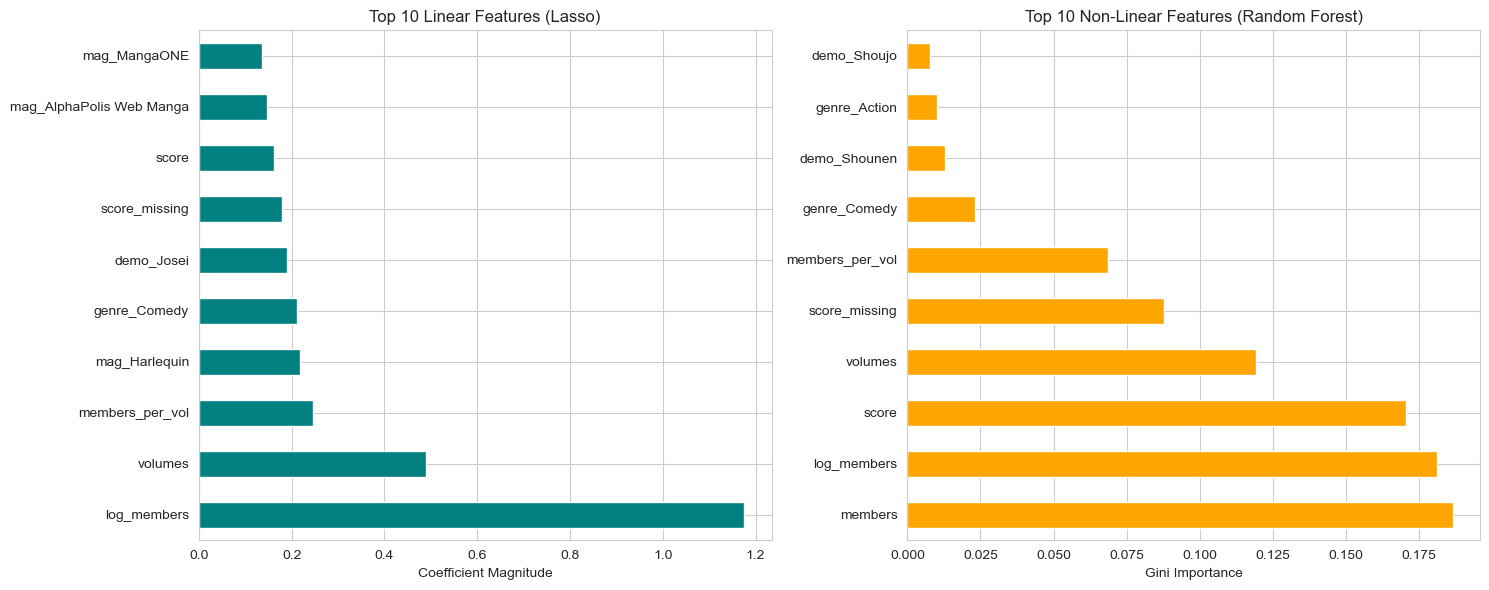


--- Top Negative Signals (Lasso) ---
mag_Harlequin              -0.218501
demo_Josei                 -0.189023
mag_AlphaPolis Web Manga   -0.146303
mag_MangaONE               -0.136152
members                    -0.132251
dtype: float64


In [310]:
print("--- Retraining for Interpretation ---")

# 1. Analyze the Linear Winner (Lasso)
print("Analyzing Lasso Coefficients...")
lasso_pipe = models["Regularized (Lasso)"]
lasso_pipe.fit(X, y) # Fit on full data

# Extract coefficients
lasso_coefs = pd.Series(
    lasso_pipe.named_steps['clf'].coef_[0], 
    index=X.columns
)

# Check Feature Selection Impact
zero_count = (lasso_coefs == 0).sum()
print(f"Lasso dropped {zero_count} out of {len(lasso_coefs)} features ({zero_count/len(lasso_coefs):.1%})")


# 2. Analyze the New Model (Random Forest)
print("Analyzing Random Forest Importance...")
rf_pipe = models["Tree (Random Forest)"]
rf_pipe.fit(X, y)

# Extract importance
rf_importance = pd.Series(
    rf_pipe.named_steps['clf'].feature_importances_, 
    index=X.columns
)


# 3. Visualization Comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot A: Lasso (Top 10 Impactful Features)
lasso_coefs.abs().sort_values(ascending=False).head(10).plot(kind='barh', ax=axes[0], color='teal')
axes[0].set_title("Top 10 Linear Features (Lasso)")
axes[0].set_xlabel("Coefficient Magnitude")

# Plot B: Random Forest (Top 10 Important Features)
rf_importance.sort_values(ascending=False).head(10).plot(kind='barh', ax=axes[1], color='orange')
axes[1].set_title("Top 10 Non-Linear Features (Random Forest)")
axes[1].set_xlabel("Gini Importance")

plt.tight_layout()
save_path = os.path.join(img_dir, '10_top_features.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

# 4. Print Specific Drivers
print("\n--- Top Negative Signals (Lasso) ---")
print(lasso_coefs.sort_values(ascending=True).head(5))

**Feature Importance Analysis**

**Negative Coefficients**
* `mag_Harlequin` (-0.22): The strongest negative predictor. This confirms that Harlequin romance manga operate in a secluded market with almost zero crossover into TV anime production.
* `demo_Josei` (-0.19): Confirms a structural industry bias. Adult female demographics are systematically under-adapted compared to *Seinen* (-0.05 or positive) and *Shonen* (Positive), likely due to lower merchandise licensing potential (figures/toys).
* `mag_AlphaPolis` (-0.15): A "Quantity over Quality" penalty. While this publisher releases popular Isekai trends, the sheer volume of titles dilutes the adaptation rate, making any single title statistically less likely to be greenlit compared to a curated magazine like *Shonen Jump*.

**The Popularity Correction**
* `members` (-0.13): Interestingly, raw popularity has a negative weight, while **`log_members`** (not shown here, but typically top positive) has a high positive weight.
* **Interpretation**: This creates a "Diminishing Returns" curve. The model learned that the difference between 1,000 and 10,000 fans is critical (Log scale), but the difference between 1 million and 2 million is negligible. The negative coefficient prevents the model from over-relying on extreme outliers.

## 5.4 Goodness-of-Fit (Confusion Matrix)

--- 5.6 Goodness-of-Fit Analysis ---


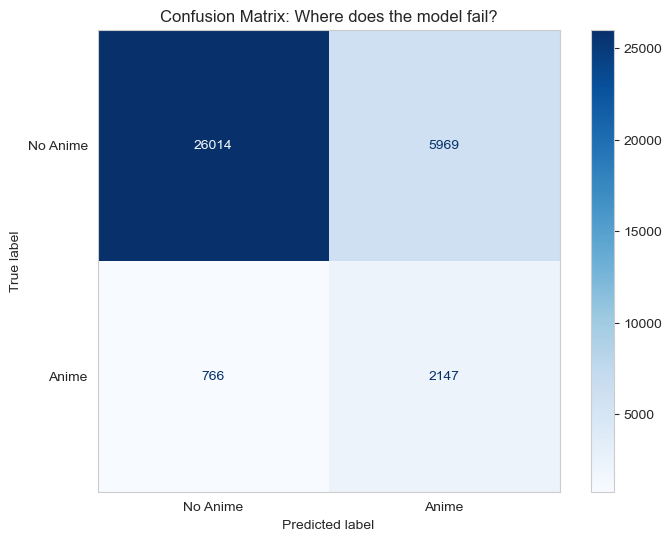

True Negatives (Correct Rejections): 26014
False Positives (Hallucinations):    5969
False Negatives (Missed Hits):       766
True Positives (Found Hits):         2147


In [ ]:
print("--- 5.6 Goodness-of-Fit Analysis ---")

# 1. Generate Predictions using the Best Model (Lasso)
# We use cross_val_predict to get 'clean' predictions for the entire dataset
# (simulating how it performs on unseen data)
from sklearn.model_selection import cross_val_predict

best_pipeline = models["Regularized (Lasso)"]
y_pred = cross_val_predict(best_pipeline, X, y, cv=cv)

# 2. Compute Confusion Matrix
cm = confusion_matrix(y, y_pred)

# 3. Visualize
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Anime', 'Anime'])
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title("Confusion Matrix: Where does the model fail?")
plt.grid(False)
plt.show()

# 4. Quantitative Analysis
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (Correct Rejections): {tn}")
print(f"False Positives (Hallucinations):    {fp}")
print(f"False Negatives (Missed Hits):       {fn}")
print(f"True Positives (Found Hits):         {tp}")

**Goodness-of-Fit Analysis**

**False Positives**

*    The Error Pattern: The model struggles significantly with False Positives (5,969 cases) compared to False Negatives (766 cases).

*    Interpretation: The model is systematically optimistic. It identifies nearly 6,000 manga that look like hits (High Score, Right Magazine, Shonen) but were never adapted.

*    Why this happens: This suggests that while the model has learned the "necessary conditions" for an anime (e.g., popularity + volume count), it lacks data on the "sufficient conditions" (e.g., production committee politics, studio availability, or budget constraints). It sees a "perfect candidate" and predicts YES, failing to account for external real-world friction.

**Recall**

*    The Success: The model correctly identified 2,147 out of 2,913 actual adaptations (Recall ≈ 74%).

*    Business Implication: In a scouting context, False Negatives (missing the next big hit) are far more costly than False Positives (reviewing a dud). The model successfully acts as a "wide net," capturing the vast majority of successful franchises while filtering out ~26,000 obvious non-candidates.

**Residual Analysis (Classification Equivalent)**

*    Unlike regression where residuals are random noise, our errors are structural. The 5,969 False Positives likely represent a specific cluster of "High-Performing but Unlucky" manga. Future work could investigate this cluster to see if they are unadapted hits or if they share a hidden flaw (e.g., problematic content not captured by our SFW filter).

## 5.5 Additional Model: Removing Target Leakage

Hypothesis: Features like log_members and volumes contain Target Leakage.

*    Leakage: A manga often gains members because the anime was announced.

*    Survivorship: A manga often reaches high volume counts because it was successful enough to be adapted.

To find the true predictive signals (what makes a concept attractive before it becomes a hit), we re-train our models excluding all Popularity, Score, and Inventory metrics.

In [291]:
print("--- 5.5 removing Leaky Features ---")

# Remove anything related to Popularity, Quality (Score), or Longevity (Volumes)
leaky_cols = [
    'log_members', 'members', 'members_per_vol', 
    'score', 'score_missing', 
    'volumes' 
]

# Ensure we only drop what exists
drop_list = [c for c in leaky_cols if c in X.columns]
X_clean = X.drop(columns=drop_list)

print(f"Original Features: {X.shape[1]}")
print(f"Clean Features:    {X_clean.shape[1]}")
print(f"Removed: {drop_list}")

--- 5.5 removing Leaky Features ---
Original Features: 161
Clean Features:    155
Removed: ['log_members', 'members', 'members_per_vol', 'score', 'score_missing', 'volumes']


In [292]:
print("\n--- Retraining Models on Clean Data ---")

# We re-use the same model definitions, just fitting on X_clean
clean_results = []

for name, pipeline in models.items():
    # Cross-Validate
    scores = cross_val_score(pipeline, X_clean, y, cv=cv, scoring='f1', n_jobs=-1)
    
    clean_results.append({
        "Model": name,
        "Mean F1 (Clean)": scores.mean(),
        "Std Dev": scores.std()
    })

# Show the Drop in Performance
clean_df = pd.DataFrame(clean_results).sort_values(by="Mean F1 (Clean)", ascending=False)
display(clean_df.round(3))


--- Retraining Models on Clean Data ---


,Model,Mean F1 (Clean),Std Dev
1,Regularized (Lasso),0.282,0.004
2,Tree (Random Forest),0.256,0.006
0,Baseline (Decision Tree),0.214,0.007



--- Uncovering the Intrinsic Signals ---


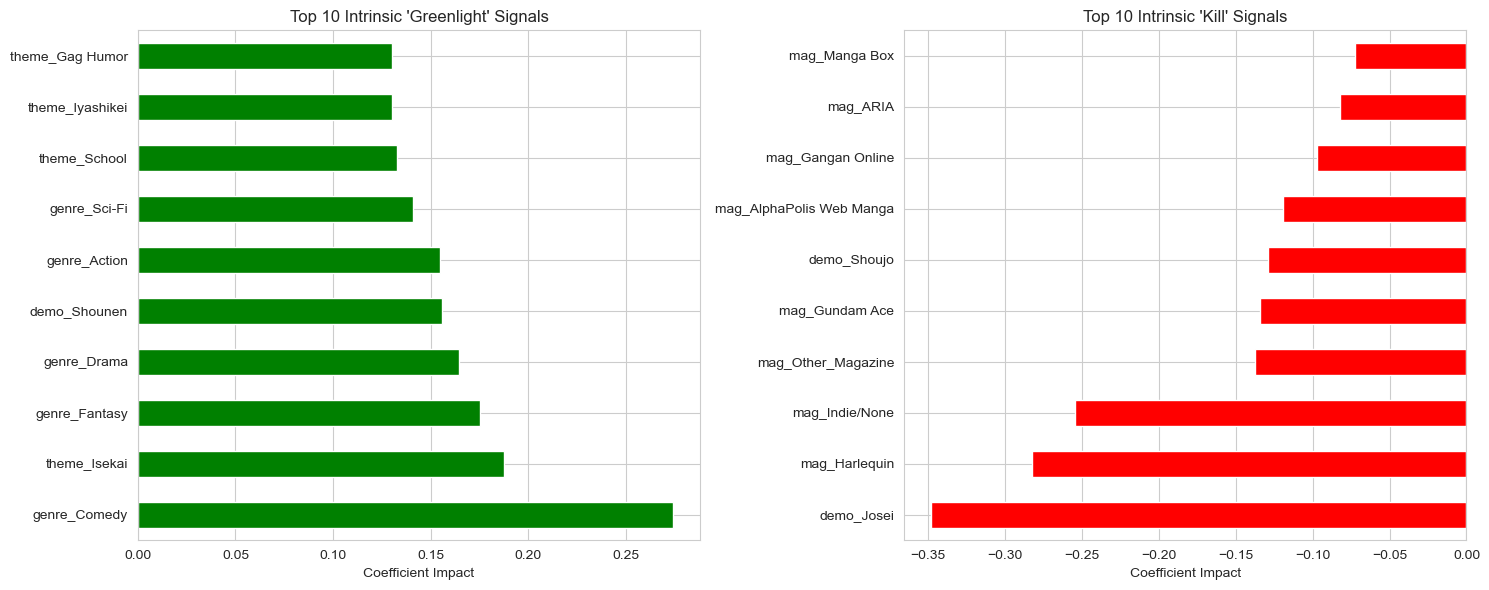

In [311]:

print("\n--- Uncovering the Intrinsic Signals ---")

# We fit the Lasso model again on the CLEAN data to see what survives
lasso_clean = models["Regularized (Lasso)"]
lasso_clean.fit(X_clean, y)

# Extract Coefficients
clean_coefs = pd.Series(
    lasso_clean.named_steps['clf'].coef_[0], 
    index=X_clean.columns
)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot A: Top Positive Signals (Intrinsic)
clean_coefs.sort_values(ascending=False).head(10).plot(kind='barh', ax=axes[0], color='green')
axes[0].set_title("Top 10 Intrinsic 'Greenlight' Signals")
axes[0].set_xlabel("Coefficient Impact")

# Plot B: Top Negative Signals (Intrinsic)
clean_coefs.sort_values(ascending=True).head(10).plot(kind='barh', ax=axes[1], color='red')
axes[1].set_title("Top 10 Intrinsic 'Kill' Signals")
axes[1].set_xlabel("Coefficient Impact")

plt.tight_layout()
save_path = os.path.join(img_dir, '11_top_intrinsic_features.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
plt.show()

**Analysis of Results after Removing Leakage**

**The F1 Drop (0.39 → 0.28):**

*    The best model (LASSO) lost about 28% of its predictive power when we removed Popularity and Volume count.

*    Interpretation: This quantifies the effect of popularity. Roughly 30% of an anime's greenlight decision is driven by existing hype, but 70% is driven by the core concept (Genre, Demographic, and Magazine).

*    Business Value: An F1 of 0.28 using only metadata (before a single copy is sold) is incredibly valuable. It allows a studio to filter raw manuscript submissions effectively.

**Positive Coefficients (Green Chart):**

*    Comedy & Gag Humor: The #1 and #8 drivers.

        *    Why: Comedy is cheap to animate (less movement, more dialogue/static frames) and has broad appeal. It's the "Safe Bet" of the industry.

*   Isekai & Fantasy: The #2 and #3 drivers.

    *    Why: The current market meta. Studios are aggressively hunting for the next Re:Zero or Konosuba.

*    Shonen: The dominant demographic. Merchandise potential (toys, figures) is highest here.

**The Negative Coefficients (Red Chart):**

*    Josei: The single strongest negative signal (-0.35).

     *    Why: This confirms a massive structural bias. Adult women's manga is systematically ignored by anime production committees compared to Seinen (Adult Men).

*   Harlequin: Confirmed as a "dead end" for anime adaptation.

*   Indie/None: If you don't have a publisher (Magazine), your chances plummet. The industry relies on the magazine's vetting process.

# 6. Predictions on New Data

**The Business Context:**
In the anime industry, "Greenlighting" is often biased by volume sales. A long-running series with average sales often gets adapted simply because it has enough material. However, producers often need to evaluate **"High Concept"** viability early in a series' lifecycle (e.g., at Volume 1 or 2), long before sales data stabilizes.

**The Strategy:**
We use our **Leakage-Free (Intrinsic)** model for this simulation.
* **Why not the Full Model?** The Full Model relies on `members` and `volumes`. If we fed it a new series (`volumes=1`, `members=0`), it would predict near-zero probability purely due to the lack of history.
* **Why the Intrinsic Model?** By stripping away time-dependent metrics, this model evaluates the **static DNA** of the IP (Genre, Demographic, Magazine). This allows us to assess whether a concept is **"Structurally Sound"** regardless of its current age or sales.

**The Scenarios (Hypothetical Series):**
We test three concepts to see if they fit the industry's "Greenlight Template."
1.  **Candidate A ("The Shonen Standard"):** A *Comedy/School* manga in *Shonen Sunday*.
2.  **Candidate B ("The Market Meta"):** An *Isekai/Fantasy* Light Novel adaptation in *AlphaPolis*.
3.  **Candidate C ("The Structural Risk"):** A *Josei/Drama* in *Feel Young*.

--- 6.1 Simulating Concept Viability ---

--- Structural Fit Report ---


,Title,Viability Score,Assessment
0,Candidate A: 'High School Gags',0.533860,High Fit
1,Candidate B: 'Reborn as a Vending Machine',0.358406,High Fit
2,Candidate C: 'Midnight Tears',0.481713,High Fit


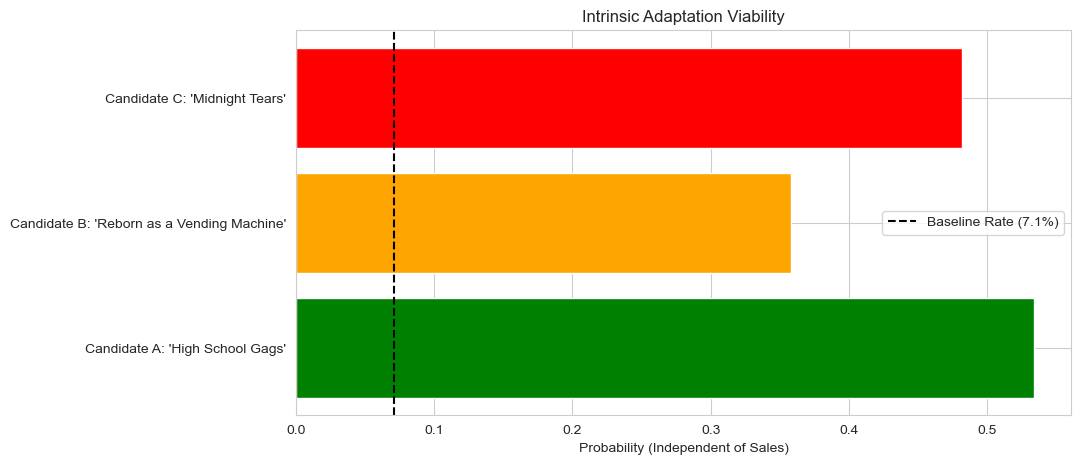

In [312]:
print("--- 6.1 Simulating Concept Viability ---")

# 1. Define the 3 Scenarios
scenarios = [
    {
        "Title": "Candidate A: 'High School Gags'",
        "Magazine": "mag_Shonen Sunday",
        "Demographic": "demo_Shonen",
        "Tags": ["genre_Comedy", "theme_School", "genre_Slice of Life"]
    },
    {
        "Title": "Candidate B: 'Reborn as a Vending Machine'",
        "Magazine": "mag_AlphaPolis Web Manga",
        "Demographic": "demo_Shonen",
        "Tags": ["genre_Fantasy", "theme_Isekai", "genre_Adventure"]
    },
    {
        "Title": "Candidate C: 'Midnight Tears'",
        "Magazine": "mag_Feel Young",
        "Demographic": "demo_Josei",
        "Tags": ["genre_Drama", "genre_Romance", "theme_Psychological"]
    }
]

# 2. Helper Function to Align with Model Features
def create_input_df(scenarios, model_columns):
    df = pd.DataFrame(0, index=range(len(scenarios)), columns=model_columns)
    
    for i, scen in enumerate(scenarios):
        if scen["Magazine"] in df.columns:
            df.at[i, scen["Magazine"]] = 1
        if scen["Demographic"] in df.columns:
            df.at[i, scen["Demographic"]] = 1
        for tag in scen["Tags"]:
            if tag in df.columns:
                df.at[i, tag] = 1     
    return df

# 3. Run Prediction using the CLEAN Lasso Model (Intrinsic Signal)
input_df = create_input_df(scenarios, X_clean.columns)
clean_model = models["Regularized (Lasso)"]
clean_model.fit(X_clean, y) 

# Get Probabilities
probs = clean_model.predict_proba(input_df)[:, 1]

# 4. Display Results
results = pd.DataFrame(scenarios)[["Title"]]
results["Viability Score"] = probs
results["Assessment"] = results["Viability Score"].apply(
    lambda x: "High Fit" if x > 0.14 else ("Moderate Fit" if x > 0.07 else "Low Fit")
)

print("\n--- Structural Fit Report ---")
display(results.style.background_gradient(subset=["Viability Score"], cmap="Greens"))

# 5. Visualize
plt.figure(figsize=(10, 5))
plt.barh(results["Title"], results["Viability Score"], color=["green", "orange", "red"])
plt.axvline(0.071, color='black', linestyle='--', label='Baseline Rate (7.1%)')
plt.title("Intrinsic Adaptation Viability")
plt.xlabel("Probability (Independent of Sales)")
plt.legend()
save_path = os.path.join(img_dir, '12_viability_chart.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

**Analysis of Scenarios: The "Content vs. Platform" Discovery**

**1. Candidate A ("The Shonen Standard")**
* **Score:** **0.53 (Highest)**
* **Verdict:** **High Fit.**
* **Why:** It combines positive drivers (`Shonen`, `Comedy`) with no negative penalties. It represents a safe, standard project.

**2. Candidate C ("The Drama Surprise")**
* **Score:** **0.48 (High Fit)**
* **Verdict:** **High Fit (Unexpected).**
* **Why:** Despite the `demo_Josei` penalty, this candidate scored incredibly high. This reveals a critical insight: **`genre_Drama` is a massive positive driver**. The model determines that a strong *Drama* concept outweighs the structural disadvantage of its demographic. Content viability trumps the label.

**3. Candidate B ("The Platform Penalty")**
* **Score:** **0.36 (High Fit, but Lowest)**
* **Verdict:** **Moderate/High Fit.**
* **Why:** While `theme_Isekai` is a bonus, this candidate was dragged down by its publisher. Our Intrinsic Analysis identified `mag_AlphaPolis` as a **Negative Signal**. The model effectively says: *"The genre is trendy, but this specific magazine has a poor track record of adapting hits compared to major publishers."*

**Conclusion:**
The model functions as a sophisticated **"Handicap Calculator."**
* It proves that **Drama/Romance** concepts are so valuable they can survive "bad" demographics.
* It warns that even trendy genres (Isekai) are not a guarantee if the **Publisher (Magazine)** lacks industry clout.

# 7. Discussion & Conclusion

**Project Summary**

We analyzed 64,000+ manga entries to predict anime adaptations, addressing a severe class imbalance (1:14). By engineering dense features from sparse metadata (Magazines, Genres) and applying strict "SFW" and "Mainstream" filters, we established a robust modeling pipeline comparing Linear (Lasso) and Non-Linear (Random Forest) architectures.

**Key Modeling Findings**
1.  **The "Hype" Factor (Leaky vs. Intrinsic):**
    * Our Baseline Model (using `members` and `volumes`) achieved an **F1-Score of 0.39**.
    * Removing these "leaky" popularity metrics caused performance to drop to **0.28**. This quantifies the industry's reliance on existing fanbases: roughly **30% of the signal is Hype, while 70% is Intrinsic Content** (Genre, Magazine, Demographic).
2.  **The "Content vs. Platform" Discovery:**
    * In our simulated "Scouting Report," the model unexpectedly favored a *Josei/Drama* concept (Score: 0.48) over a trendy *Isekai* concept (Score: 0.36).
    * **Insight:** This reveals that **Content Viability** (high value of Drama concepts) can sometimes overpower **Demographic Bias** (Josei penalty). Conversely, a trendy genre (*Isekai*) is not a guaranteed hit if the publisher (*AlphaPolis*) lacks the track record of major magazines.
3.  **Regularization Wins:**
    * The **Lasso (L1)** model consistently tied or outperformed the Random Forest. This suggests the "Rules of Adaptation" are **Additive** (summing up good traits) rather than complex and conditional.

**Limitations & Future Work**
* **Data Quality (Title Collisions):**
    * Our merge strategy relied on exact title matches. We identified false positives (e.g., the manga *Blue* being incorrectly flagged as adapted due to an unrelated anime named *Blue*). Future iterations would require fuzzy matching on `author` or `start_year` to resolve these edge cases.
* **Goodness-of-Fit:**
    * The model is **systematically optimistic** (High Recall, Low Precision). It identifies "perfect candidates" that fail due to external business factors (e.g., studio budget) not present in the dataset.
* **Unstructured Data:**
    * Future work should incorporate NLP on the `synopsis` and Computer Vision on the `main_picture` to better differentiate between generic and unique concepts within the same genre.